# 공용처리

In [483]:
## Retail_dataset.xlsx
import sklearn as sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

In [484]:
import platform

def set_matplotlib_font():
    system = platform.system()

    if system == "Windows":
        plt.rc('font', family='Malgun Gothic')
    elif system == "Darwin":  # macOS
        plt.rc('font', family='AppleGothic')
    elif system == "Linux":
        plt.rc('font', family='NanumGothic')
    else:
        print("Unknown system. Please set font manually.")

    plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 함수 호출
set_matplotlib_font()

# 이후 평소대로 matplotlib 사용

In [485]:
pd.describe_option()
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', None)

compute.use_bottleneck : bool
    Use the bottleneck library to accelerate if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
compute.use_numba : bool
    Use the numba engine option for select operations if it is installed,
    the default is False
    Valid values: False,True
    [default: False] [currently: False]
compute.use_numexpr : bool
    Use the numexpr library to accelerate computation if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
display.chop_threshold : float or None
    if set to a float value, all float values smaller than the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]
display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]
display.date_dayfirst : boolean
    When True, prints an

- 컬럼 추가 우선, 컬럼 삭제는 merge 후 최종 단계에!
- 

# 데이터 불러오기

In [486]:
retail_dataset = pd.read_excel('C:/Users/양영/Documents/Jupyter/TF2/Retail_dataset.xlsx', sheet_name=None)

In [487]:
# !kaggle datasets download -d quangvinhhuynh/marketing-and-retail-analyst-e-comerce
# import shutil
# filename = 'marketing-and-retail-analyst-e-comerce.zip' # 압축 해제할 파일 이름
# extrac_dir = 'dataset' # 압축 해제할 폴더 이름
# archive_format = 'zip' # 압축 파일 형태
# shutil.unpack_archive(filename, extrac_dir, archive_format)
# import os
# # 파일들이 있는 폴더명으로 폴더내 파일 목록 확인
# os.listdir('dataset/') 
# customers_df= pd.read_csv('dataset/customers.csv')
# orders_df= pd.read_csv('dataset/orders.csv')
# order_items_df= pd.read_csv('dataset/order_items.csv')
# payments_df= pd.read_csv('dataset/payments.csv')
# products_df= pd.read_csv('dataset/products.csv')

In [488]:
orders_df = retail_dataset['orders']
order_items_df = retail_dataset['order_items']
customers_df = retail_dataset['customers']
payments_df = retail_dataset['payments']
products_df = retail_dataset['products']

# 데이터 전처리

## ID 형 변환 (int -> str)

### order_items_df

In [489]:
order_items_df['order_item_id'] = order_items_df['order_item_id'].astype(str)

## product_df 결측치 처리

In [490]:
#제품 크기에 대한 정보가 없는 레코드가 2개 -> 삭제 처리
products_df= products_df[products_df['product_category_name'].notnull()]
products_df= products_df[products_df['product_length_cm'].notnull()]

## product_volume 추가

In [491]:
products_df['product_volume'] = products_df['product_length_cm'] *  products_df['product_height_cm'] *  products_df['product_width_cm'] 

# 데이터 병합 진행

In [492]:
retail_df_merged = pd.merge(orders_df, order_items_df, on='order_id', how='left')
retail_df_merged = pd.merge(retail_df_merged, payments_df, on='order_id', how='left')
retail_df_merged = pd.merge(retail_df_merged, customers_df, on='customer_id', how='right')
retail_df_merged = pd.merge(retail_df_merged, products_df, on='product_id', how='right')

In [493]:
payments_grouped_order_id= payments_df.groupby('order_id').agg({
    'payment_value': 'sum'
}).reset_index()
payments_grouped_order_id = payments_grouped_order_id.rename(columns={'payment_value':'payment_value_sum'})
retail_df_merged= pd.merge(retail_df_merged, payments_grouped_order_id, on= 'order_id', how= 'left')

## order_id별 price 파생변수 생성

In [494]:
order_items_grouped_order_id= order_items_df.groupby('order_id').agg({
    'price': 'sum'
    , 'shipping_charges': 'sum'
}).reset_index()
order_items_grouped_order_id['total_price']=order_items_grouped_order_id['price']+order_items_grouped_order_id['shipping_charges']

In [495]:
retail_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127097 entries, 0 to 127096
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       127097 non-null  object        
 1   customer_id                    127097 non-null  object        
 2   order_status                   127097 non-null  object        
 3   order_purchase_timestamp       127097 non-null  datetime64[ns]
 4   order_approved_at              127081 non-null  datetime64[ns]
 5   order_delivered_timestamp      124354 non-null  datetime64[ns]
 6   order_estimated_delivery_date  127097 non-null  datetime64[ns]
 7   order_item_id                  127097 non-null  object        
 8   product_id                     127097 non-null  object        
 9   seller_id                      127097 non-null  object        
 10  price                          127097 non-null  float64       
 11  

# 불필요한 컬럼 삭제

In [496]:
# delivered 만
retail_df_merged = retail_df_merged[retail_df_merged['order_status']=='delivered']
retail_df_merged = retail_df_merged[retail_df_merged['order_delivered_timestamp'].notnull()]
retail_df_merged = retail_df_merged[retail_df_merged['order_approved_at'].notnull()]

# 컬럼 삭제
retail_df_merged= retail_df_merged.drop(labels= 'customer_zip_code_prefix', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'customer_city', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'order_estimated_delivery_date', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'order_delivered_timestamp', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'product_width_cm', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'product_height_cm', axis= 1)
retail_df_merged= retail_df_merged.drop(labels= 'product_length_cm', axis= 1)


## order - purchased_month

<Axes: xlabel='count', ylabel='payment_monthly'>

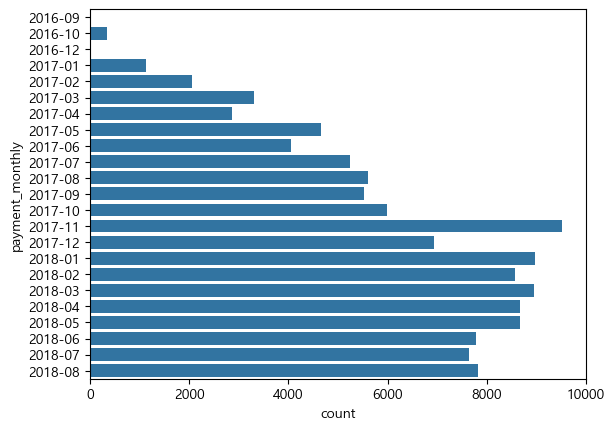

In [497]:
retail_df_merged['order_purchase_timestamp']= pd.to_datetime(retail_df_merged['order_purchase_timestamp'])
retail_df_merged['order_purchase_timestamp'].dt.strftime('%Y-%m')
retail_df_merged['payment_monthly']= retail_df_merged['order_purchase_timestamp'].dt.strftime('%Y-%m')
retail_df_merged['payment_monthly']= pd.to_datetime(retail_df_merged['payment_monthly'])
retail_df_merged['payment_monthly']= retail_df_merged['order_purchase_timestamp'].dt.to_period('M')

sns.countplot(data= retail_df_merged, y= retail_df_merged['payment_monthly']
              , order= sorted(retail_df_merged['payment_monthly']))

## customer_state 원핫인코딩
- 1200개 이상 값만

SP 사람들만 군집화해도 됨. 룰..베이스 + 머신러닝 결합
해보고나서 성능 안좋다싶으면 줄여도 ok

In [498]:
# state_counts= retail_df_merged['customer_state'].value_counts()
# state_above_1200= state_counts[state_counts>1200].index
# retail_df_merged= retail_df_merged[retail_df_merged['customer_state'].isin(state_above_1200)]
# retail_df_merged['customer_state'].value_counts()


# from sklearn.preprocessing import OneHotEncoder
# oe= OneHotEncoder(sparse_output=False) # 배열형태

# oe.fit(retail_df_merged[['customer_state']])

# state_csr = oe.transform(retail_df_merged[['customer_state']])
# state_csr_df = pd.DataFrame(state_csr, columns= oe.get_feature_names_out())
# # 배열형태로 했으니 toarray() 삭제

# # state_csr_df 인덱스 초기화
# state_csr_df.reset_index(drop= True, inplace= True)

# retail_df_merged= pd.concat([retail_df_merged.reset_index(drop= True), state_csr_df], axis= 1)
# retail_df_merged

## payment_type 원핫인코딩

In [499]:
from sklearn.preprocessing import OneHotEncoder
oe= OneHotEncoder(sparse_output=False) # 배열형태

retail_df_merged['payment_type'].value_counts()
# not_defined        4개 지우고 원핫인코딩
retail_df_merged['payment_type'].isna().sum()

# not_defined 제외
pay_type = retail_df_merged['payment_type'].value_counts()
defined_payment = pay_type[pay_type.index != 'not_defined'].index
retail_df_merged= retail_df_merged[retail_df_merged['payment_type'].isin(defined_payment)]
retail_df_merged['payment_type'].value_counts()

oe.fit(retail_df_merged[['payment_type']])
payment_csr = oe.transform(retail_df_merged[['payment_type']])
payment_csr_df = pd.DataFrame(payment_csr, columns= oe.get_feature_names_out())
payment_csr_df.reset_index(drop= True, inplace= True)

retail_df_merged= pd.concat([retail_df_merged.reset_index(drop= True), payment_csr_df], axis= 1)
retail_df_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,SP,perfumery,225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,RJ,art,1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,SP,sports_leisure,154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0


## category_name 분류하기

In [500]:
# 'category_column'이 null이 아닌 데이터만 필터링
filtered_df = retail_df_merged[retail_df_merged['product_category_name'].notna()]

In [501]:
# 각 범주에 속하는 항목 리스트를 정의
home_living = [
    'housewares', 'furniture_decor', 'small_appliances', 'bed_bath_table',
    'kitchen_dining_laundry_garden_furniture', 'home_comfort', 'furniture_living_room',
    'home_appliances', 'home_appliances', 'home_construction', 'home_comfort',
    'furniture_bedroom', 'furniture_mattress_and_upholstery', 'garden_tools',
    'construction_tools_construction', 'construction_tools_safety', 'construction_tools_lights',
    'costruction_tools_garden', 'costruction_tools','pet_shop','baby', 'diapers_and_hygiene', 'fashion_childrens_clothes', 'air_conditioning'
]

fashion_accessories = [
    'fashion_underwear_beach', 'fashion_bags_accessories', 'fashion_shoes',
    'fashion_sport', 'fashion_male_clothing', 'fashion_childrens_clothes',
    'fashio_female_clothing', 'watches_gifts', 'luggage_accessories'
]

electronics_appliances = [
    'electronics', 'telephony', 'computers_accessories', 'computers',
    'tablets_printing_image', 'audio', 'small_appliances_home_oven_and_coffee',
    'cine_photo', 'consoles_games', 'fixed_telephony'
]

hobbies_leisure = [
    'sports_leisure', 'musical_instruments', 'party_supplies', 'christmas_supplies',
    'art', 'arts_and_craftmanship', 'music', 'dvds_blu_ray', 'books_general_interest',
    'books_technical', 'books_imported', 'flowers','auto','cool_stuff','health_beauty', 'perfumery'
]

baby_kids = ['toys']

office_industry = [
    'stationery', 'office_furniture', 'industry_commerce_and_business',
    'agro_industry_and_commerce', 'signaling_and_security', 'security_and_services'
]

food_beverage = ['food', 'drinks', 'food_drink','cuisine','market_place']

In [502]:
# 각 범주의 갯수를 세는 함수
def count_items_in_category(df, category_list):
    return df[df['product_category_name'].isin(category_list)].shape[0]

# 필터링된 데이터프레임을 사용하여 각 범주의 항목 수 계산
home_living_count = count_items_in_category(retail_df_merged, home_living)
fashion_accessories_count = count_items_in_category(retail_df_merged, fashion_accessories)
electronics_appliances_count = count_items_in_category(retail_df_merged, electronics_appliances)
hobbies_leisure_count = count_items_in_category(retail_df_merged, hobbies_leisure)
baby_kids_count = count_items_in_category(retail_df_merged, baby_kids)
office_industry_count = count_items_in_category(retail_df_merged, office_industry)
food_beverage_count = count_items_in_category(retail_df_merged, food_beverage)


# 결과 출력
print(f"집 관련 (Home & Living): {home_living_count}개")
print(f"패션 관련 (Fashion & Accessories): {fashion_accessories_count}개")
print(f"전자제품 및 기기 (Electronics & Appliances): {electronics_appliances_count}개")
print(f"취미 및 여가 (Hobbies & Leisure): {hobbies_leisure_count}개")
print(f"아동 관련 (Baby & Kids): {baby_kids_count}개")
print(f"사무용품 및 산업 (Office & Industry): {office_industry_count}개")
print(f"식품 및 음료 (Food & Beverage): {food_beverage_count}개")


집 관련 (Home & Living): 11374개
패션 관련 (Fashion & Accessories): 2586개
전자제품 및 기기 (Electronics & Appliances): 5038개
취미 및 여가 (Hobbies & Leisure): 9506개
아동 관련 (Baby & Kids): 93644개
사무용품 및 산업 (Office & Industry): 1609개
식품 및 음료 (Food & Beverage): 350개


#### 할부기간(단기/장기 나누기) : median 값 기준으로 나누기 , 레이블 인코딩 하기

In [503]:
retail_df_merged.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,SP,perfumery,225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,RJ,art,1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0


In [504]:
# payment관련 컬럼들의 결측치 3개가 존재하는데 이거 모두 삭제해주기
# 'payment_installments' 컬럼에서 결측치가 있는 행만 삭제
retail_df_merged = retail_df_merged.dropna(subset=['payment_installments','payment_type','payment_value'])
retail_df_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,SP,perfumery,225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,RJ,art,1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,SP,sports_leisure,154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0


In [505]:
# 중앙값 구하기
payment_installments_median = retail_df_merged['payment_installments'].median()
payment_installments_median 

np.float64(2.0)

In [506]:
# 단기와 장기로 나누기
def classify_installments(installments, median):
    if installments <= median:
        return 'Short-Term'
    else:
        return 'Long-Term'
    
    
retail_df_merged['payment_installments_category'] = retail_df_merged['payment_installments'].apply(lambda x: classify_installments(x, payment_installments_median))

In [507]:
retail_df_merged['payment_installments_category'].value_counts()

payment_installments_category
Short-Term    76117
Long-Term     48211
Name: count, dtype: int64

In [508]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
retail_df_merged['payment_installments_category'] = label_encoder.fit_transform(retail_df_merged['payment_installments_category'])

retail_df_merged['payment_installments_category'].value_counts() ## 1:단기 / 0: 장기

payment_installments_category
1    76117
0    48211
Name: count, dtype: int64

In [509]:
retail_df_merged.isna().sum()
# 결측치 존재 X 확인

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_state                   0
product_category_name            0
product_weight_g                 0
product_volume                   0
payment_value_sum                0
payment_monthly                  0
payment_type_credit_card         0
payment_type_debit_card          0
payment_type_voucher             0
payment_type_wallet              0
payment_installments_category    0
dtype: int64

In [510]:
# 월별 매출 = month_value 컬럼 생성

month_value= retail_df_merged.groupby('payment_monthly').payment_value.sum()
month_value

retail_df_merged['payment_monthly_sum']= retail_df_merged['payment_monthly'].map(month_value)

In [511]:
month_value

payment_monthly
2016-10      64288.22
2016-12         39.24
2017-01     193772.21
2017-02     337776.25
2017-03     537697.94
2017-04     484812.57
2017-05     768889.21
2017-06     638324.38
2017-07     792862.63
2017-08     919573.82
2017-09    1070266.38
2017-10    1081309.90
2017-11    1675466.29
2017-12    1097486.10
2018-01    1469974.38
2018-02    1431389.57
2018-03    1540269.36
2018-04    1573819.86
2018-05    1582326.72
2018-06    1352854.01
2018-07    1391770.10
2018-08    1348941.79
Freq: M, Name: payment_value, dtype: float64

In [512]:
print(retail_df_merged['product_category_name'].unique())

['perfumery' 'art' 'sports_leisure' 'baby' 'housewares'
 'musical_instruments' 'cool_stuff' 'furniture_decor' 'home_appliances'
 'toys' 'bed_bath_table' 'construction_tools_safety'
 'computers_accessories' 'health_beauty' 'luggage_accessories'
 'garden_tools' 'office_furniture' 'auto' 'electronics' 'fashion_shoes'
 'telephony' 'stationery' 'fashion_bags_accessories' 'computers'
 'home_construction' 'watches_gifts' 'construction_tools_construction'
 'pet_shop' 'small_appliances' 'agro_industry_and_commerce'
 'furniture_living_room' 'signaling_and_security' 'air_conditioning'
 'consoles_games' 'books_general_interest' 'costruction_tools_tools'
 'fashion_underwear_beach' 'fashion_male_clothing'
 'kitchen_dining_laundry_garden_furniture'
 'industry_commerce_and_business' 'fixed_telephony'
 'construction_tools_lights' 'books_technical' 'home_appliances_2'
 'party_supplies' 'drinks' 'market_place' 'la_cuisine'
 'costruction_tools_garden' 'fashio_female_clothing' 'home_confort'
 'audio' 'food

<Axes: xlabel='payment_monthly', ylabel='payment_value'>

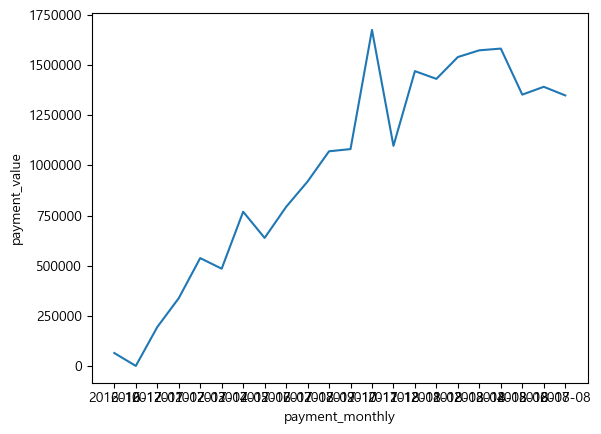

In [513]:
# day_sum 기준 그래프
day_sum = pd.DataFrame(retail_df_merged.groupby('payment_monthly').payment_value.sum()).reset_index()

plt.ticklabel_format(style='plain')
sns.lineplot(data= day_sum, x=day_sum['payment_monthly'].astype(str)
             ,y= day_sum['payment_value']
              )

# 최종 데이터프레임

In [514]:
retail_df_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_item_id', 'product_id', 'seller_id',
       'price', 'shipping_charges', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_state',
       'product_category_name', 'product_weight_g', 'product_volume',
       'payment_value_sum', 'payment_monthly', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher',
       'payment_type_wallet', 'payment_installments_category',
       'payment_monthly_sum'],
      dtype='object')

# 표준화

In [515]:
from sklearn.preprocessing import StandardScaler
sd_sc1 = StandardScaler()
retail_df_merged['shipping_charges_sd_sc'] = sd_sc1.fit_transform(retail_df_merged[['shipping_charges']])
sd_sc2 = StandardScaler()
retail_df_merged['price_sd_sc'] = sd_sc1.fit_transform(retail_df_merged[['price']])
sd_sc3 = StandardScaler()
retail_df_merged['payment_value_sd_sc'] = sd_sc1.fit_transform(retail_df_merged[['payment_value']])
sd_sc4 = StandardScaler()
retail_df_merged['product_volume_sd_sc'] = sd_sc1.fit_transform(retail_df_merged[['product_volume']])

# 빈도 인코딩
- customer_state, payment_type, 카테고리 네임

In [516]:
retail_df_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_item_id', 'product_id', 'seller_id',
       'price', 'shipping_charges', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_state',
       'product_category_name', 'product_weight_g', 'product_volume',
       'payment_value_sum', 'payment_monthly', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher',
       'payment_type_wallet', 'payment_installments_category',
       'payment_monthly_sum', 'shipping_charges_sd_sc', 'price_sd_sc',
       'payment_value_sd_sc', 'product_volume_sd_sc'],
      dtype='object')

In [517]:
retail_df_merged['customer_state'].unique()
# 12

array(['SP', 'RJ', 'MG', 'BA', 'PI', 'RS', 'PE', 'SC', 'MT', 'AL', 'CE',
       'ES', 'DF', 'TO', 'GO', 'PA', 'RN', 'PR', 'PB', 'SE', 'MS', 'MA',
       'AM', 'AC', 'RO', 'AP', 'RR'], dtype=object)

In [518]:
# !pip install feature_engine

In [519]:
retail_df_merged['customer_state_origin'] = retail_df_merged['customer_state']

In [520]:
from feature_engine.encoding import CountFrequencyEncoder

encoder= CountFrequencyEncoder(
    encoding_method= 'count',
    variables= 'customer_state')

encoder.fit(retail_df_merged)

encoder= CountFrequencyEncoder(
    encoding_method= 'frequency',
    variables= 'customer_state')

encoder.fit(retail_df_merged)

encoder.encoder_dict_


{'customer_state': {'SP': 0.4238063831156296,
  'RJ': 0.12956051734122642,
  'MG': 0.11614439225275079,
  'RS': 0.055948780644746156,
  'PR': 0.05067241490251593,
  'SC': 0.036355446882439996,
  'BA': 0.03393443150376424,
  'DF': 0.020735473907727946,
  'GO': 0.02037352808699569,
  'ES': 0.020164403835017053,
  'PE': 0.016295605173412265,
  'CE': 0.012507238916414646,
  'MT': 0.009281899491667203,
  'PA': 0.009233640048902902,
  'MS': 0.00714239752911653,
  'MA': 0.007126311048195097,
  'PB': 0.005364841387298115,
  'RN': 0.004697252429058619,
  'PI': 0.004697252429058619,
  'AL': 0.0037320635737726014,
  'SE': 0.003329901550736761,
  'TO': 0.002799047680329451,
  'RO': 0.0026462261115758317,
  'AM': 0.0015282156875361945,
  'AC': 0.0008284537674538318,
  'AP': 0.0006997619200823628,
  'RR': 0.00039411878257512384}}

In [521]:
retail_df_merged= encoder.fit_transform(retail_df_merged)

In [522]:
retail_df_merged['payment_type'].value_counts()

payment_type
credit_card    91724
wallet         24084
voucher         6786
debit_card      1734
Name: count, dtype: int64

# 클러스터링

<Axes: xlabel='product_volume', ylabel='payment_value'>

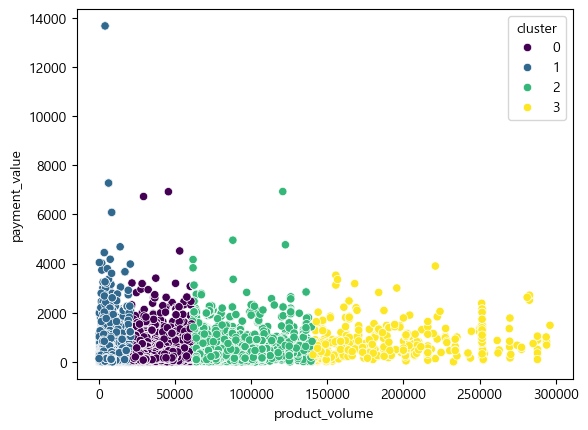

In [523]:
# K-Means Clustering
# 인코딩 한 거 아직 안 넣음!
continuous_col = ['price', 'shipping_charges', 
                  'payment_sequential', 'payment_installments', 
                  'payment_value', 'product_volume']

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(retail_df_merged[continuous_col])
kmeans_test_df = retail_df_merged.copy()
kmeans_test_df['cluster'] = kmeans.labels_
sns.scatterplot(data=kmeans_test_df,
                x= 'product_volume',
                y='payment_value',
                hue='cluster',
                palette='viridis'
                )

In [524]:
# 엘보우

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow(X):
    sse = [] # 군집 내 거리의 합
    for i in range(1, 11):
        km = KMeans(n_clusters=i, init='k-means++', random_state=42)
        km.fit(X)
        sse.append(km.inertia_)
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()

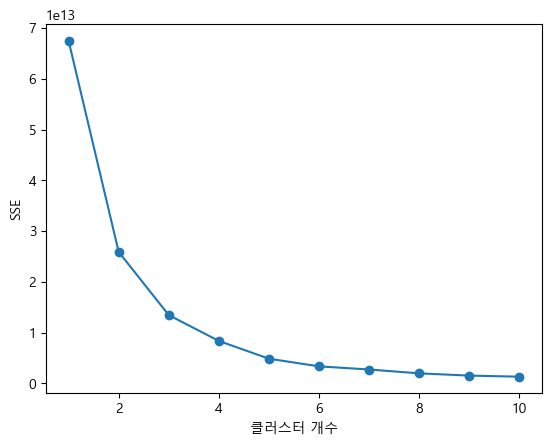

In [525]:
elbow(kmeans_test_df[continuous_col])
# 4개!!!

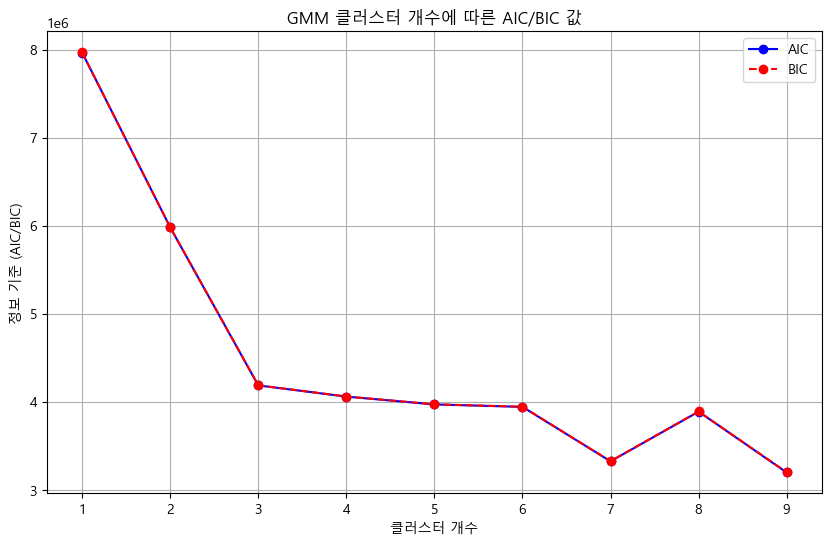

In [526]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
def gmm_elbow(X):
    aic = []
    bic = []
    components = range(1,10)
    for i in components:
        gmm = GaussianMixture(n_components=i, random_state=0)
        gmm.fit(X)
        aic.append(gmm.aic(X))
        bic.append(gmm.bic(X))
    plt.figure(figsize=(10, 6))
    plt.plot(components, aic, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(components, bic, marker='o', linestyle='--', color='r', label='BIC')
    plt.xlabel('클러스터 개수')
    plt.ylabel('정보 기준 (AIC/BIC)')
    plt.title('GMM 클러스터 개수에 따른 AIC/BIC 값')
    plt.legend()
    plt.grid(True)
    plt.show()
gmm_elbow(kmeans_test_df[continuous_col])


# 표준화

In [527]:
# 'price', 'shipping_charge', 'payment_value', 'product_volume' 표준화: 
# 이유: raw 데이터가 치우쳐져 있다. 이상치 존재.

In [528]:
retail_df_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,0.423806,perfumery,225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,-0.803888,-0.597789,-0.583768,-0.556545,SP
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,0.129561,art,1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0,1,1469974.38,-0.122774,0.719451,0.358488,-0.189217,RJ
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,0.423806,sports_leisure,154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0,1,1391770.10,-0.776258,-0.215045,-0.320063,-0.548392,SP


In [529]:
from sklearn.preprocessing import StandardScaler
sd_sc1 = StandardScaler()
retail_df_merged['shipping_charges_sd_sc'] = sd_sc1.fit_transform(retail_df_merged[['shipping_charges']])
sd_sc2 = StandardScaler()
retail_df_merged['price_sd_sc'] = sd_sc2.fit_transform(retail_df_merged[['price']])
sd_sc3 = StandardScaler()
retail_df_merged['payment_value_sd_sc'] = sd_sc3.fit_transform(retail_df_merged[['payment_value']])
sd_sc4 = StandardScaler()
retail_df_merged['product_volume_sd_sc'] = sd_sc4.fit_transform(retail_df_merged[['product_volume']])
sd_sc5 = StandardScaler()
retail_df_merged['product_weight_g_sd_sc'] = sd_sc5.fit_transform(retail_df_merged[['product_weight_g']])
sd_sc6 = StandardScaler()
retail_df_merged['payment_value_sum_sd_sc'] = sd_sc6.fit_transform(retail_df_merged[['payment_value_sum']])

# BERT 적용 전 전처리

In [530]:
retail_df_merged['product_category_name'] = retail_df_merged['product_category_name'].replace('home_confort', 'home_comfort')
retail_df_merged['product_category_name'] = retail_df_merged['product_category_name'].replace('costruction_tools_tools', 'costruction_tools')
retail_df_merged['product_category_name'] = retail_df_merged['product_category_name'].replace('la_cuisine', 'cuisine')

In [531]:
retail_df_merged[retail_df_merged['product_category_name']== 'costruction_tools_tools'].count()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_state                   0
product_category_name            0
product_weight_g                 0
product_volume                   0
payment_value_sum                0
payment_monthly                  0
payment_type_credit_card         0
payment_type_debit_card          0
payment_type_voucher             0
payment_type_wallet              0
payment_installments_category    0
payment_monthly_sum              0
shipping_charges_sd_sc           0
price_sd_sc                      0
payment_value_sd_sc 

In [532]:
# 카테고리명 정리 함수
def remove_suffix(item):
    return item.replace('_2', '')
retail_df_merged['product_category_name'] = retail_df_merged['product_category_name'].apply(remove_suffix)

In [533]:
# origin 남겨두기
retail_df_merged['product_category_name_origin'] = retail_df_merged['product_category_name']

In [534]:
# 언더바, and 값으로 단어들 나누는 함수 정의
def category_split(item):
    and_split = item.split('and')
    split_name = []
    for part in and_split:
        for word in part.split('_'):
            if word:  # 빈 문자열이 아닐 경우에만 추가
                split_name.append(word.strip())  # 공백 제거 후 추가
    return split_name

retail_df_merged['product_category_name']= retail_df_merged['product_category_name'].apply(category_split)

In [535]:
retail_df_merged.head(15)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,0.423806,[perfumery],225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,-0.803888,-0.597789,-0.583768,-0.556545,SP,-0.496429,-0.603629,perfumery
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,0.129561,[art],1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0,1,1469974.38,-0.122774,0.719451,0.358488,-0.189217,RJ,-0.290064,0.325866,art
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,0.423806,"[sports, leisure]",154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0,1,1391770.10,-0.776258,-0.215045,-0.320063,-0.548392,SP,-0.515335,-0.343495,sports_leisure
3,143d00a4f2dde4e0364ee1821577adb3,619e926d09b26efbd5180368b1ddc874,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,1,cef67bcfe19066a932b7673e239eb23d,c510bc1718f0f2961eaa42a23330681a,112.30,9.54,1.0,credit_card,2.0,121.84,0.423806,[baby],371.0,2704.0,121.84,2018-08,1.0,0.0,0.0,0.0,1,1348941.79,-0.665738,-0.034480,-0.189884,-0.536634,SP,-0.457552,-0.215079,baby
4,86cafb8794cb99a9b1b77fc8e48fbbbb,ad353b4fb0e294adc4eda48af73e68a6,delivered,2018-04-11 01:06:37,2018-04-11 01:30:23,1,9dc1a7de274444849c219cff195d0b71,0be8ff43f22e456b4e0371b2245e4d01,37.90,8.29,1.0,credit_card,4.0,46.19,0.423806,[housewares],625.0,4420.0,46.19,2018-04,1.0,0.0,0.0,0.0,0,1573819.86,-0.746058,-0.447836,-0.477670,-0.462997,SP,-0.389918,-0.498967,housewares
5,c214058828b43a44f352b56ff2d5c0a5,8b28d6ec6f6a9124310e82e5a55f35de,delivered,2018-03-12 15:41:41,2018-03-13 15:48:29,1,41d3672d4792049fa1779bb35283ed13,ce248b21cb2adc36282ede306b7660e5,45.87,19.95,1.0,credit_card,5.0,65.82,0.116144,"[musical, instruments]",200.0,2090.0,65.82,2018-03,1.0,0.0,0.0,0.0,0,1540269.36,0.003168,-0.403556,-0.402994,-0.562982,MG,-0.503086,-0.425303,musical_instruments
6,c6343db6c1801f9c3301166f02931116,3256bccea9c8aa521d29257b56c54f88,delivered,2017-12-05 11:14:58,2017-12-05 12:01:44,1,732bd381ad09e530fe0a5f457d81becb,8b8cfc8305aa441e4239358c9f6f2485,968.00,44.30,1.0,credit_card,1.0,1012.30,0.129561,"[cool, stuff]",18350.0,73920.0,1012.30,2017-12,1.0,0.0,0.0,0.0,1,1097486.10,1.567804,4.719673,3.197579,2.519404,RJ,4.329859,3.126511,cool_stuff
7,9632facd8bd95315d63a23bf616d85b0,f7495a8d48d05ca657eb075b905a1b8b,delivered,2018-01-14 12:31:15,2018-01-14 12:39:24,1,732bd381ad09e530fe0a5f457d81becb,8b8cfc8305aa441e4239358c9f6f2485,958.00,27.76,1.0,credit_card,5.0,985.76,0.423806,"[cool, stuff]",18350.0,73920.0,985.76,2018-01,1.0,0.0,0.0,0.0,0,1469974.38,0.505008,4.664114,3.096617,2.519404,SP,4.329859,3.026915,cool_stuff
8,6ecf7023e8dd4ec8b08746c35b9fcb60,8fe54925e8ff1067c803ae7026fe384b,delivered,2017-11-24 14:22:48,2017-11-24 16:33:43,3,2548af3e6e77a690cf3eb6368e9ab61e,95f83f51203c626648c875dd41874c7f,9.99,16.02,1.0,credit_card,3.0,163.88,0.423806,"[furniture, decor]",900.0,12800.0,163.88,2017-11,1.0,0.0,0.0,0.0,0,1675466.29,-0.249358,-0.602900,-0.029956,-0.103392,SP,-0.316691,

In [536]:
retail_df_merged['product_category_name_origin'].value_counts()

product_category_name_origin
toys                                 93644
health_beauty                         3299
bed_bath_table                        3058
sports_leisure                        2578
furniture_decor                       2453
                                     ...  
fashion_sport                            4
fashion_childrens_clothes                2
furniture_mattress_and_upholstery        2
diapers_and_hygiene                      1
security_and_services                    1
Name: count, Length: 68, dtype: int64

#toys 일시적 삭제

In [537]:
retail_df_merged = retail_df_merged[retail_df_merged['product_category_name_origin']!='toys']

In [538]:
retail_df_merged['product_category_name_origin'].value_counts()

product_category_name_origin
health_beauty                        3299
bed_bath_table                       3058
sports_leisure                       2578
furniture_decor                      2453
computers_accessories                2399
                                     ... 
fashion_sport                           4
fashion_childrens_clothes               2
furniture_mattress_and_upholstery       2
diapers_and_hygiene                     1
security_and_services                   1
Name: count, Length: 67, dtype: int64

In [539]:
category_list= {"home_living": home_living, "fashion_accessories": fashion_accessories, "electronics_appliances": electronics_appliances, 
                "hobbies_leisure": hobbies_leisure, "office_industry": office_industry, "food_beverage": food_beverage}
                # "hobbies_leisure": hobbies_leisure, "baby_kids": baby_kids, "office_industry": office_industry, "food_beverage": food_beverage}
# dict 타입으로 변환. 키값:home_living, 밸류: 해당 값.

def product_categorizing(product):
    for key, value in category_list.items():
        if product in value:
            return key
        
retail_df_merged["product_category_name_cf_en"] = retail_df_merged['product_category_name_origin'].apply(product_categorizing)


# 빈도수 인코딩 (product_category)

In [540]:
from feature_engine.encoding import CountFrequencyEncoder

encoder= CountFrequencyEncoder(
    encoding_method= 'count',
    variables= 'product_category_name_cf_en')
encoder.fit(retail_df_merged)

encoder= CountFrequencyEncoder(
    encoding_method= 'frequency',
    variables= 'product_category_name_cf_en')
encoder.fit(retail_df_merged)
retail_df_merged= encoder.fit_transform(retail_df_merged)

In [541]:
retail_df_merged['product_category_name_cf_en'].isna().sum()

np.int64(0)

In [542]:
retail_df_merged[retail_df_merged['product_category_name_cf_en'].isna()].head(250)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en


In [543]:
retail_df_merged[retail_df_merged['product_category_name_cf_en'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en


In [544]:
retail_df_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,0.423806,[perfumery],225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,-0.803888,-0.597789,-0.583768,-0.556545,SP,-0.496429,-0.603629,perfumery,0.309803
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,0.129561,[art],1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0,1,1469974.38,-0.122774,0.719451,0.358488,-0.189217,RJ,-0.290064,0.325866,art,0.309803
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,0.423806,"[sports, leisure]",154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0,1,1391770.10,-0.776258,-0.215045,-0.320063,-0.548392,SP,-0.515335,-0.343495,sports_leisure,0.309803


In [578]:
col_needed = [
              'price_sd_sc', #같은 PRODUCT라도 가격이 변할 수 있음
              'shipping_charges_sd_sc',
#              'payment_sequential',
#              'payment_installments', # 0개
              'payment_value_sd_sc', #ORDER_ID / 지불순서 / 컬럼 다수 -> ITEM #
#              'customer_state',
#              'product_weight_g_sd_sc',
              'product_volume_sd_sc',
              'payment_type_credit_card',
              'payment_type_debit_card',
              'payment_type_voucher',
              'payment_type_wallet',
              'payment_installments_category',
              ]

#13

In [546]:
# PCA 수행
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)  # 2개의 주성분으로 축소 # 낮을수록 손실은 크다
pca_result = pca.fit_transform(retail_df_merged[col_needed])
# 차원축소 기법 - pca
# 인코딩 진행 후(데이터 차원 많아진 후) pca 진행

In [547]:
pca_result

array([[-1.34397909, -0.22415399],
       [ 0.10662146,  0.77399905],
       [-1.0857253 ,  0.19049563],
       ...,
       [-0.27934815,  1.05847353],
       [-0.27934815,  1.05847353],
       [-0.48778233, -0.70956652]])

In [548]:
# 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

<Axes: >

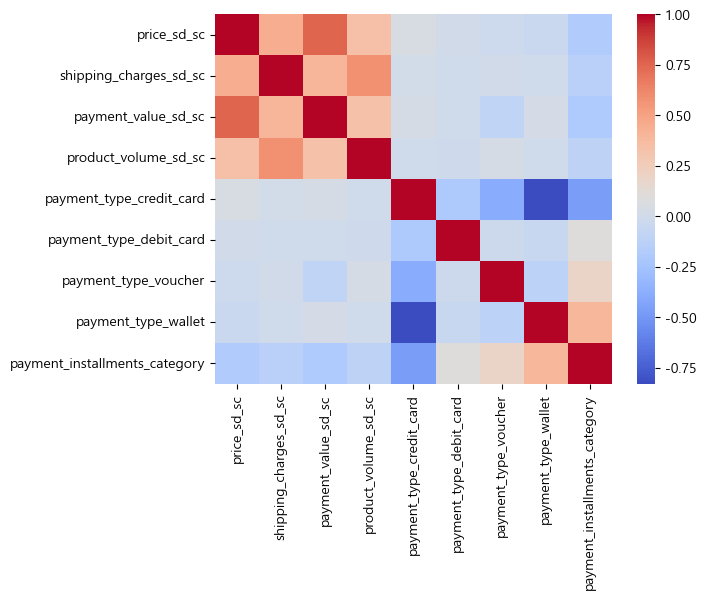

In [579]:
sns.heatmap(retail_df_merged[col_needed].corr(), cmap="coolwarm")

In [580]:
retail_df_merged[col_needed].head()

,price_sd_sc,shipping_charges_sd_sc,payment_value_sd_sc,product_volume_sd_sc,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category
0,-0.597789,-0.803888,-0.583768,-0.556545,0.0,1.0,0.0,0.0,1
1,0.719451,-0.122774,0.358488,-0.189217,0.0,0.0,1.0,0.0,1
2,-0.215045,-0.776258,-0.320063,-0.548392,1.0,0.0,0.0,0.0,1
3,-0.034480,-0.665738,-0.189884,-0.536634,1.0,0.0,0.0,0.0,1
4,-0.447836,-0.746058,-0.477670,-0.462997,1.0,0.0,0.0,0.0,0


In [581]:
pca_df.head()
#, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']

,PC1,PC2,Cluster
0,-1.343979,-0.224154,0
1,0.106621,0.773999,1
2,-1.085725,0.190496,0
3,-0.882743,0.334688,1
4,-1.057561,-0.053288,0


주성분 분석 후 클러스터링은 오히려 쉽지 않을 수 있음
 

In [583]:
# kmeans 모델 생성
kmeans = KMeans(n_clusters=4, random_state=42)

# kmeans 모델 훈련
kmeans.fit(retail_df_merged[col_needed])

# 클러스터 할당
clusters = kmeans.predict(retail_df_merged[col_needed])

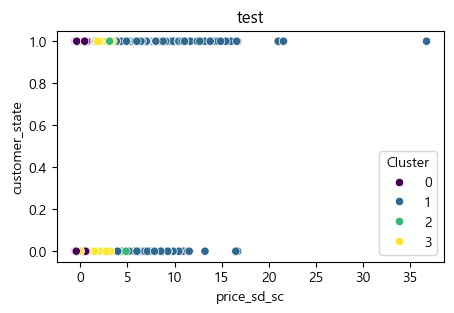

In [584]:
# 클러스터 할당 결과를 데이터프레임에 추가
retail_df_merged['Cluster'] = clusters
# bad_customers['Cluster'] = clusters

plt.figure(figsize=(5, 3))
# sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
sns.scatterplot(x='price_sd_sc', y='payment_type_credit_card', hue = 'Cluster', data=retail_df_merged, palette='viridis')
# kmeans 와 pca 
plt.title('test')
plt.xlabel('price_sd_sc')
plt.ylabel('customer_state')
plt.show()

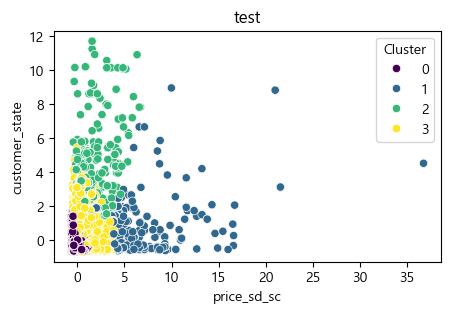

In [585]:
# 클러스터 할당 결과를 데이터프레임에 추가
retail_df_merged['Cluster'] = clusters
# bad_customers['Cluster'] = clusters

plt.figure(figsize=(5, 3))
# sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
sns.scatterplot(x='price_sd_sc', y='product_volume_sd_sc', hue = 'Cluster', data=retail_df_merged, palette='viridis')
# kmeans 와 pca 
plt.title('test')
plt.xlabel('price_sd_sc')
plt.ylabel('customer_state')
plt.show()

In [586]:
retail_df_merged.groupby(['customer_id','Cluster']).agg({
    'price_sd_sc':'mean',
    'product_volume_sd_sc':'max', #n
    'customer_state': 'median'
}).sort_values(by=['customer_id','Cluster']) #nlogn

,,price_sd_sc,product_volume_sd_sc,customer_state
customer_id,Cluster,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,0,-0.553397,-0.431757,0.423806
0005e1862207bf6ccc02e4228effd9a0,0,0.091639,-0.369448,0.129561
000de6019bb59f34c099a907c151d855,0,0.118862,-0.158534,0.423806
000ed48ceeb6f4bf8ad021a10a3c7b43,0,-0.586843,-0.553799,0.423806
000fbf0473c10fc1ab6f8d2d286ce20c,0,0.007578,-0.539381,0.423806
...,...,...,...,...
ffeddf8aa7cdecf403e77b2e9a99e2ea,3,0.258314,-0.585726,0.009234
ffee94d548cef05b146d825a7648dab4,0,-0.503394,-0.543243,0.423806
ffeefd086fc667aaf6595c8fe3d22d54,0,-0.352830,-0.546933,0.129561


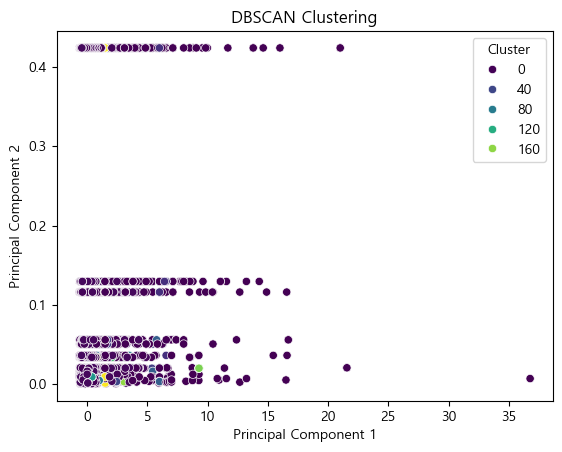

In [556]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=4)
clusters = dbscan.fit_predict(retail_df_merged[col_needed])
retail_df_merged['Cluster'] = clusters
# 결과 시각화
sns.scatterplot(x='price_sd_sc', y='customer_state',hue = 'Cluster', data=retail_df_merged, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
plt.show()

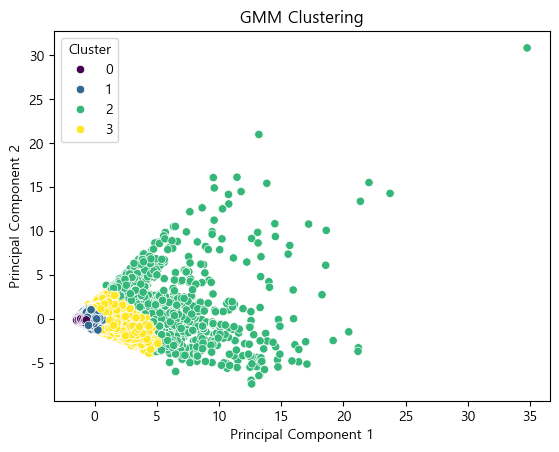

In [557]:
# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
clusters = gmm.fit_predict(pca_result)
pca_df['Cluster'] = clusters
# 군집 레이블 추가
sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM Clustering')
plt.show()


# cluster_df["gmm_label"] = gmm_label
# # GMM은 cluster_centers_ 속성이 없음
# visualize_cluster_plot(gmm, cluster_df, 'gmm_label',iscenter=False)
# print('\n### Gaussian Mixture Clustering ###')
# print(cluster_df.groupby('target')['gmm_label'].value_counts())

In [558]:
retail_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30684 entries, 0 to 31837
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       30684 non-null  object        
 1   customer_id                    30684 non-null  object        
 2   order_status                   30684 non-null  object        
 3   order_purchase_timestamp       30684 non-null  datetime64[ns]
 4   order_approved_at              30684 non-null  datetime64[ns]
 5   order_item_id                  30684 non-null  object        
 6   product_id                     30684 non-null  object        
 7   seller_id                      30684 non-null  object        
 8   price                          30684 non-null  float64       
 9   shipping_charges               30684 non-null  float64       
 10  payment_sequential             30684 non-null  float64       
 11  payment_type        

In [559]:
retail_df_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,0.423806,[perfumery],225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,-0.803888,-0.597789,-0.583768,-0.556545,SP,-0.496429,-0.603629,perfumery,0.309803,0
1,5236307716393b7114b53ee991f36956,4b86049cb99e4aa774031daa9cd18f18,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,1,3aa071139cb16b67ca9e5dea641aaa2f,b561927807645834b59ef0d16ba55a24,248.00,17.99,1.0,voucher,1.0,265.99,0.129561,[art],1000.0,10800.0,265.99,2018-01,0.0,0.0,1.0,0.0,1,1469974.38,-0.122774,0.719451,0.358488,-0.189217,RJ,-0.290064,0.325866,art,0.309803,1
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,0.423806,"[sports, leisure]",154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0,1,1391770.10,-0.776258,-0.215045,-0.320063,-0.548392,SP,-0.515335,-0.343495,sports_leisure,0.309803,2
3,143d00a4f2dde4e0364ee1821577adb3,619e926d09b26efbd5180368b1ddc874,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,1,cef67bcfe19066a932b7673e239eb23d,c510bc1718f0f2961eaa42a23330681a,112.30,9.54,1.0,credit_card,2.0,121.84,0.423806,[baby],371.0,2704.0,121.84,2018-08,1.0,0.0,0.0,0.0,1,1348941.79,-0.665738,-0.034480,-0.189884,-0.536634,SP,-0.457552,-0.215079,baby,0.377786,2
4,86cafb8794cb99a9b1b77fc8e48fbbbb,ad353b4fb0e294adc4eda48af73e68a6,delivered,2018-04-11 01:06:37,2018-04-11 01:30:23,1,9dc1a7de274444849c219cff195d0b71,0be8ff43f22e456b4e0371b2245e4d01,37.90,8.29,1.0,credit_card,4.0,46.19,0.423806,[housewares],625.0,4420.0,46.19,2018-04,1.0,0.0,0.0,0.0,0,1573819.86,-0.746058,-0.447836,-0.477670,-0.462997,SP,-0.389918,-0.498967,housewares,0.377786,3


In [560]:
retail_df_merged['order_purchase_timestamp'] = pd.to_datetime(retail_df_merged['order_purchase_timestamp'])

In [561]:
retail_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30684 entries, 0 to 31837
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       30684 non-null  object        
 1   customer_id                    30684 non-null  object        
 2   order_status                   30684 non-null  object        
 3   order_purchase_timestamp       30684 non-null  datetime64[ns]
 4   order_approved_at              30684 non-null  datetime64[ns]
 5   order_item_id                  30684 non-null  object        
 6   product_id                     30684 non-null  object        
 7   seller_id                      30684 non-null  object        
 8   price                          30684 non-null  float64       
 9   shipping_charges               30684 non-null  float64       
 10  payment_sequential             30684 non-null  float64       
 11  payment_type        

In [562]:
monthly_dfs = []

In [563]:
test_df = retail_df_merged.copy()

In [564]:
test_df = test_df[test_df['customer_state_origin']=='SP']

In [565]:
test_df['Month'] = test_df['order_purchase_timestamp'].dt.to_period('M')

In [566]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12835 entries, 0 to 31837
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       12835 non-null  object        
 1   customer_id                    12835 non-null  object        
 2   order_status                   12835 non-null  object        
 3   order_purchase_timestamp       12835 non-null  datetime64[ns]
 4   order_approved_at              12835 non-null  datetime64[ns]
 5   order_item_id                  12835 non-null  object        
 6   product_id                     12835 non-null  object        
 7   seller_id                      12835 non-null  object        
 8   price                          12835 non-null  float64       
 9   shipping_charges               12835 non-null  float64       
 10  payment_sequential             12835 non-null  float64       
 11  payment_type        

In [567]:
# 월별로 데이터프레임을 나누어 리스트에 저장
for _, group in test_df.groupby('Month'):
    monthly_dfs.append(group.drop(columns='Month'))

In [568]:
# 각 월별 데이터프레임 확인

from datetime import datetime as dt


for i, monthly_df in enumerate(monthly_dfs):
    print(f"Month {i+1}:")
    print(monthly_df['order_purchase_timestamp'].head(1).dt.year, monthly_df['order_purchase_timestamp'].head(1).dt.month)
    # print(monthly_df['order_purchase_timestamp'].head(1))
    # print(pd.to_datetime(monthly_df['order_purchase_timestamp'], format='%Y-%m'))
    # print(monthly_df.info())

#컬럼에서 유추할 수 있는 정보는 굳이 클러스터링하지 않아도 됨
#11월 - 블프....... 할인율이 높지 않다... 근데 구매량이 비정상적으로 많음

Month 1:
109    2016
Name: order_purchase_timestamp, dtype: int32 109    10
Name: order_purchase_timestamp, dtype: int32
Month 2:
1258    2017
Name: order_purchase_timestamp, dtype: int32 1258    1
Name: order_purchase_timestamp, dtype: int32
Month 3:
1155    2017
Name: order_purchase_timestamp, dtype: int32 1155    2
Name: order_purchase_timestamp, dtype: int32
Month 4:
596    2017
Name: order_purchase_timestamp, dtype: int32 596    3
Name: order_purchase_timestamp, dtype: int32
Month 5:
226    2017
Name: order_purchase_timestamp, dtype: int32 226    4
Name: order_purchase_timestamp, dtype: int32
Month 6:
34    2017
Name: order_purchase_timestamp, dtype: int32 34    5
Name: order_purchase_timestamp, dtype: int32
Month 7:
30    2017
Name: order_purchase_timestamp, dtype: int32 30    6
Name: order_purchase_timestamp, dtype: int32
Month 8:
108    2017
Name: order_purchase_timestamp, dtype: int32 108    7
Name: order_purchase_timestamp, dtype: int32
Month 9:
44    2017
Name: order_purchas

## 월별 price_sd_sc vs product_volume_sd_sc

Month 1:


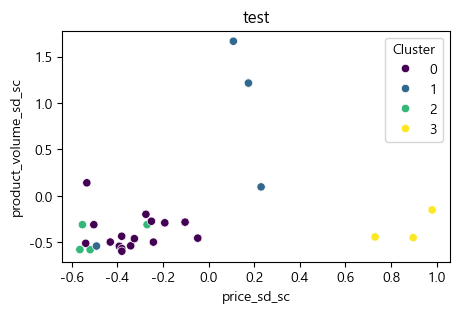

Month 2:


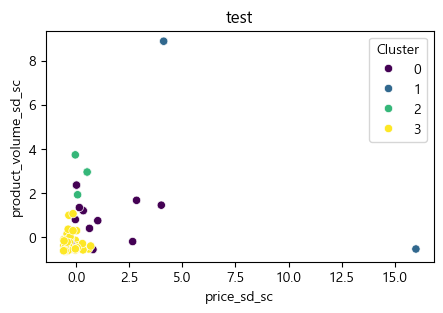

Month 3:


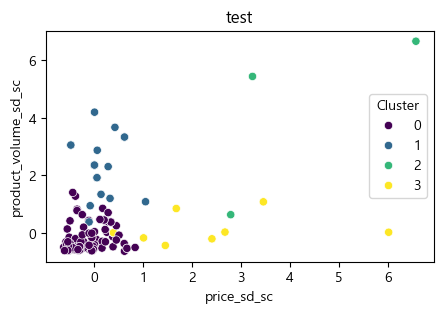

Month 4:


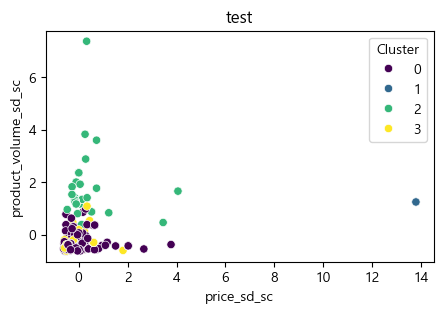

Month 5:


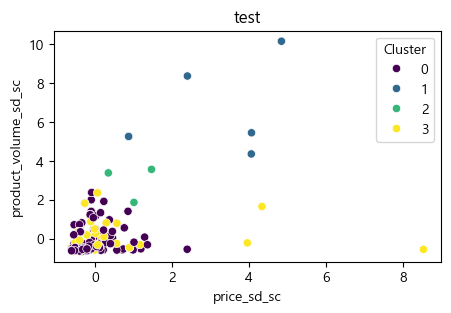

Month 6:


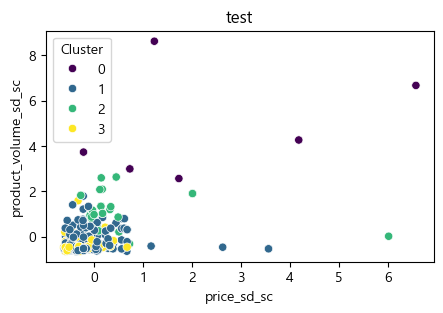

Month 7:


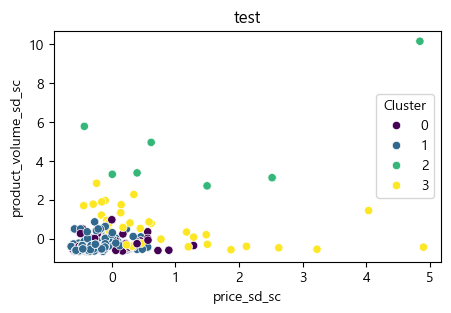

Month 8:


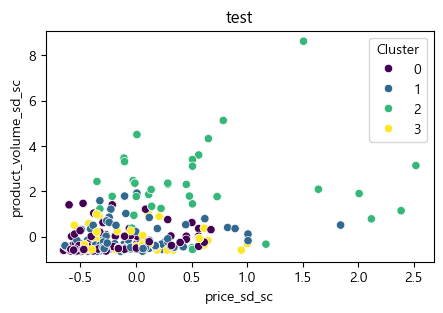

Month 9:


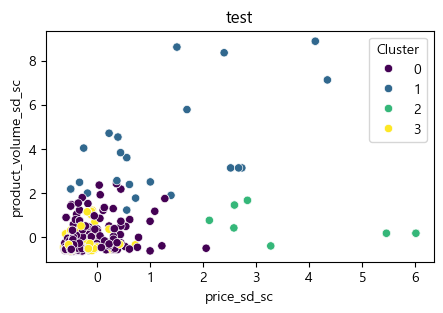

Month 10:


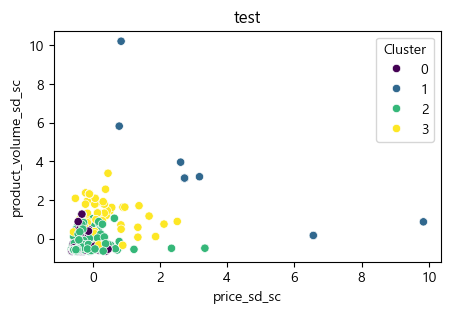

Month 11:


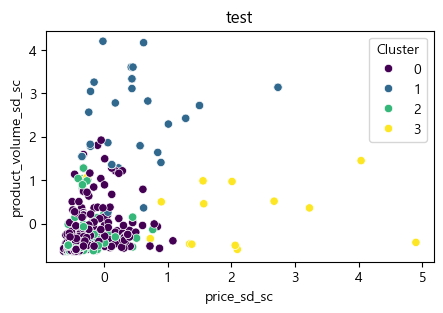

Month 12:


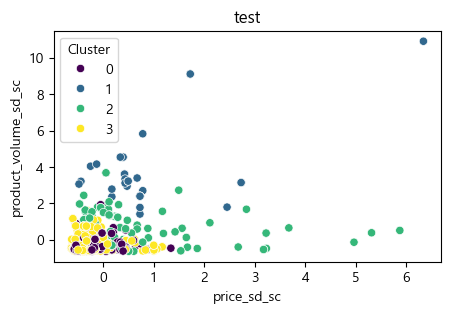

Month 13:


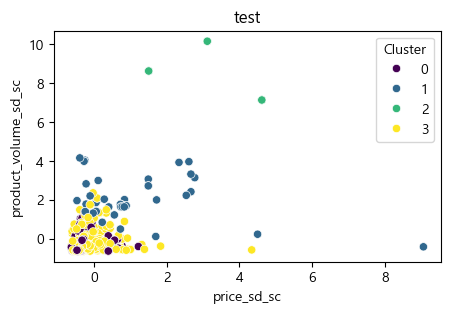

Month 14:


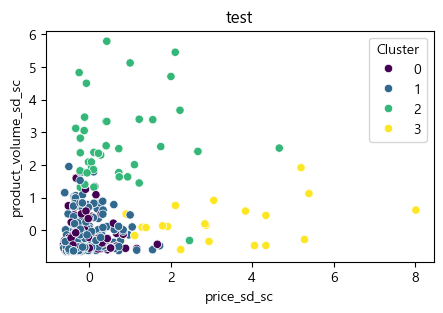

Month 15:


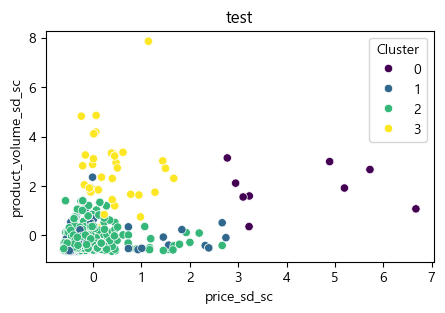

Month 16:


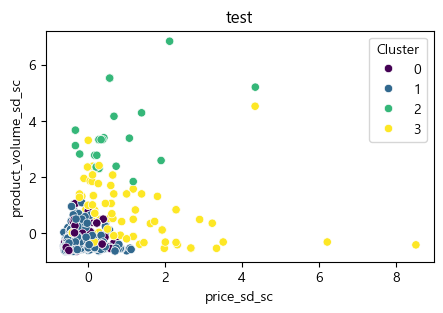

Month 17:


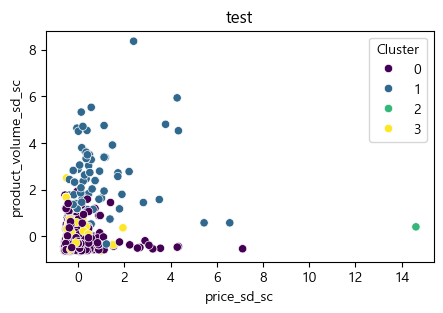

Month 18:


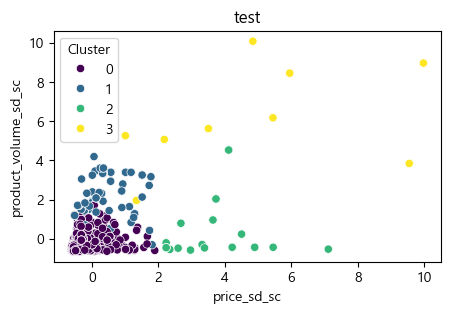

Month 19:


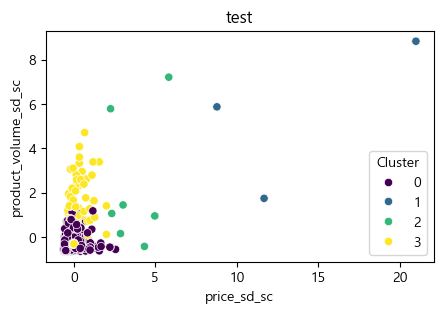

Month 20:


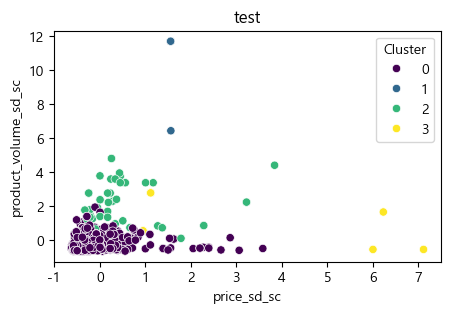

Month 21:


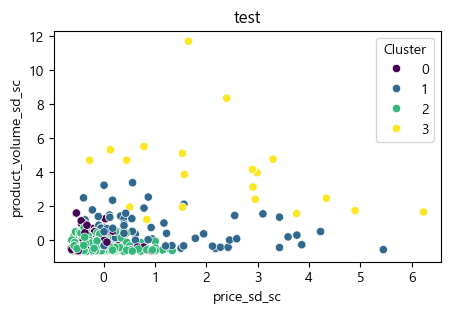

In [569]:

for i, monthly_df in enumerate(monthly_dfs):
    print(f"Month {i+1}:")
    # kmeans 모델 생성
    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(monthly_df[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(monthly_df[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    monthly_df['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='price_sd_sc', y='product_volume_sd_sc', hue = 'Cluster', data=monthly_df, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('price_sd_sc')
    plt.ylabel('product_volume_sd_sc')
    plt.show()

기존 데이터에서 11월 (월말) 에 매출이 급격하게 높아짐을 알 수 있음
이 쇼핑몰 자체의 매출이 계절성이 없다고 판단이 들만큼 수직적으로 상승하고 있다
이런 흐름에 대해서 앞으로 다가올 월말의 매출을 더 상승시키기 위해서는
기존의 고객 데이터을 기반으로 클러스터링을 진행하여
예비 고객에 대한 맞춤형 마케팅 전략을 짜는 것이 목적임

In [570]:
# 그래서 ~~(컬럼들)~에 대한 월별 매출액을 봐봤음.

# 결과 ~~~~이랬음

# 다음과 같이 고객 세분화를 진행할 수 있었음~~

# 고객층을 간단하게 설명할 수 있어야 함 -> 각 군집에 대한 설명

# 매출 상승에 가장 기여를 할 수 있는 군집은 ~~라고 생각하였음

# 이 군집의 특성을 파악해보니 다음과 같았음 (액션 도출)
# 뭘 샀는지, 어떤 결제방식 썼는지,
# 상품예치양을 늘릴 것인지,
# 커다란 제품이라면 할인....
# 바우처... 제공을 할 수도 있을거고...



## 월별 price_sd_sc vs 

In [571]:
test_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster,Month
0,e17e4f88e31525f7deef66779844ddce,b1a1199364a4a7fe27c4486ab63f550d,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,1,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,7.39,1.0,debit_card,1.0,18.30,0.423806,[perfumery],225.0,2240.0,18.30,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,-0.803888,-0.597789,-0.583768,-0.556545,SP,-0.496429,-0.603629,perfumery,0.309803,0,2018-04
2,01f66e58769f84129811d43eefd187fb,f63805d9c7edb84d92413af34b86a39c,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,1,96bd76ec8810374ed1b65e291975717f,7b07b3c7487f0ea825fc6df75abd658b,79.80,7.82,1.0,credit_card,1.0,87.62,0.423806,"[sports, leisure]",154.0,2430.0,87.62,2018-07,1.0,0.0,0.0,0.0,1,1391770.10,-0.776258,-0.215045,-0.320063,-0.548392,SP,-0.515335,-0.343495,sports_leisure,0.309803,2,2018-07
3,143d00a4f2dde4e0364ee1821577adb3,619e926d09b26efbd5180368b1ddc874,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,1,cef67bcfe19066a932b7673e239eb23d,c510bc1718f0f2961eaa42a23330681a,112.30,9.54,1.0,credit_card,2.0,121.84,0.423806,[baby],371.0,2704.0,121.84,2018-08,1.0,0.0,0.0,0.0,1,1348941.79,-0.665738,-0.034480,-0.189884,-0.536634,SP,-0.457552,-0.215079,baby,0.377786,2,2018-08
4,86cafb8794cb99a9b1b77fc8e48fbbbb,ad353b4fb0e294adc4eda48af73e68a6,delivered,2018-04-11 01:06:37,2018-04-11 01:30:23,1,9dc1a7de274444849c219cff195d0b71,0be8ff43f22e456b4e0371b2245e4d01,37.90,8.29,1.0,credit_card,4.0,46.19,0.423806,[housewares],625.0,4420.0,46.19,2018-04,1.0,0.0,0.0,0.0,0,1573819.86,-0.746058,-0.447836,-0.477670,-0.462997,SP,-0.389918,-0.498967,housewares,0.377786,3,2018-04
7,9632facd8bd95315d63a23bf616d85b0,f7495a8d48d05ca657eb075b905a1b8b,delivered,2018-01-14 12:31:15,2018-01-14 12:39:24,1,732bd381ad09e530fe0a5f457d81becb,8b8cfc8305aa441e4239358c9f6f2485,958.00,27.76,1.0,credit_card,5.0,985.76,0.423806,"[cool, stuff]",18350.0,73920.0,985.76,2018-01,1.0,0.0,0.0,0.0,0,1469974.38,0.505008,4.664114,3.096617,2.519404,SP,4.329859,3.026915,cool_stuff,0.309803,-1,2018-01


In [572]:
# 년도와 월을 기반으로 그룹핑하여 데이터프레임 리스트에 저장
monthly_dfs = []
for (year, month), group in test_df.groupby([test_df['order_purchase_timestamp'].dt.year, test_df['order_purchase_timestamp'].dt.month]):
    monthly_dfs.append((year, month, group.drop(columns=['Month'])))
# 각 년도,월별 데이터프레임 확인
for i, (year, month, monthly_df) in enumerate(monthly_dfs):
    print(f"Year {year}, Month {month}:")
    print(monthly_df.info())

Year 2016, Month 10:
<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 109 to 31151
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       39 non-null     object        
 1   customer_id                    39 non-null     object        
 2   order_status                   39 non-null     object        
 3   order_purchase_timestamp       39 non-null     datetime64[ns]
 4   order_approved_at              39 non-null     datetime64[ns]
 5   order_item_id                  39 non-null     object        
 6   product_id                     39 non-null     object        
 7   seller_id                      39 non-null     object        
 8   price                          39 non-null     float64       
 9   shipping_charges               39 non-null     float64       
 10  payment_sequential             39 non-null     float64       
 11  

In [576]:
monthly_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
3,143d00a4f2dde4e0364ee1821577adb3,619e926d09b26efbd5180368b1ddc874,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,1,cef67bcfe19066a932b7673e239eb23d,c510bc1718f0f2961eaa42a23330681a,112.3,9.54,1.0,credit_card,2.0,121.84,0.423806,[baby],371.0,2704.0,121.84,2018-08,1.0,0.0,0.0,0.0,1,1348941.79,-0.665738,-0.034480,-0.189884,-0.536634,SP,-0.457552,-0.215079,baby,0.377786,2
38,82262a82713a250e0e1f99b5111b9614,f0bc93e644b830e9d4483a9ebccec525,delivered,2018-08-04 18:36:11,2018-08-04 18:45:16,1,a0736b92e52f6cead290e30b578413b6,391fc6631aebcf3004804e51b40bcf1e,49.7,34.66,1.0,credit_card,8.0,84.36,0.423806,"[furniture, decor]",1700.0,10500.0,84.36,2018-08,1.0,0.0,0.0,0.0,0,1348941.79,0.948375,-0.382277,-0.332464,-0.202090,SP,-0.103669,-0.355728,furniture_decor,0.377786,2
56,c12bef4c2199585f7a1f2c92fdac3827,13a6bc772740dca2a4f38a5b5b6e3fb0,delivered,2018-08-06 17:46:34,2018-08-06 18:04:49,1,d03bd02af9fff4b98f1c972315e5e9ef,0241d4d5d36f10f80c644447315af0bd,69.9,18.29,1.0,credit_card,3.0,88.19,0.423806,"[furniture, decor]",1800.0,12000.0,88.19,2018-08,1.0,0.0,0.0,0.0,0,1348941.79,-0.103497,-0.270048,-0.317894,-0.137722,SP,-0.077041,-0.341356,furniture_decor,0.377786,2
58,707ecac4537ba4d942b035e0377e56e4,e3d72218a378312ea9f9b5d721a59d96,delivered,2018-08-08 11:55:41,2018-08-08 12:05:14,1,8ba4f2a4ae695d26e5626c1bf710975e,7040e82f899a04d1b434b795a43b4617,69.9,9.24,1.0,credit_card,3.0,79.14,0.423806,[housewares],900.0,12500.0,79.14,2018-08,1.0,0.0,0.0,0.0,0,1348941.79,-0.685014,-0.270048,-0.352322,-0.116266,SP,-0.316691,-0.375317,housewares,0.377786,2
69,ad979a858d9d6a2b8bbec764d452d1a9,a93d5bc325f8844f5ae36b1c9b79b3e0,delivered,2018-08-02 13:57:47,2018-08-02 14:10:21,1,051b9ff13dd55c0a6655a15ff296f80d,a45314082d50d578a4721c9787ce09ab,285.0,20.30,1.0,credit_card,2.0,305.30,0.423806,"[sports, leisure]",3600.0,32798.0,305.30,2018-08,1.0,0.0,0.0,0.0,1,1348941.79,0.025658,0.925018,0.508030,0.754767,SP,0.402259,0.473383,sports_leisure,0.309803,1


Year 2016, Month 10:


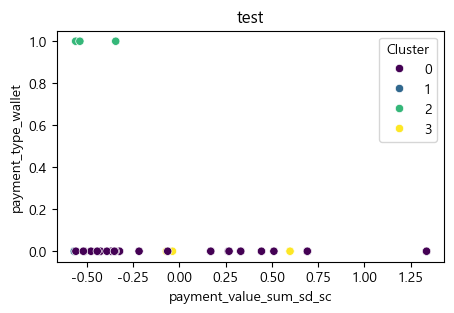

Year 2017, Month 1:


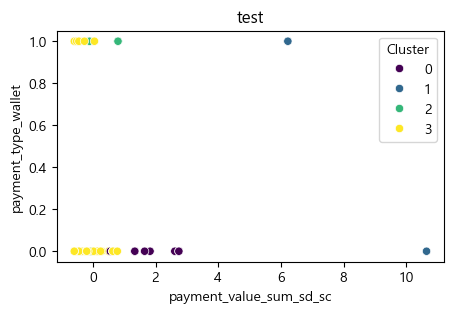

Year 2017, Month 2:


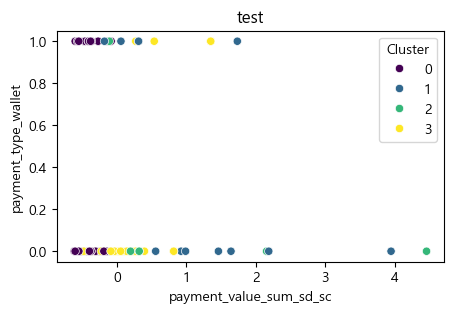

Year 2017, Month 3:


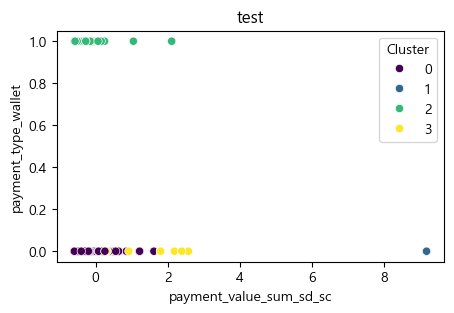

Year 2017, Month 4:


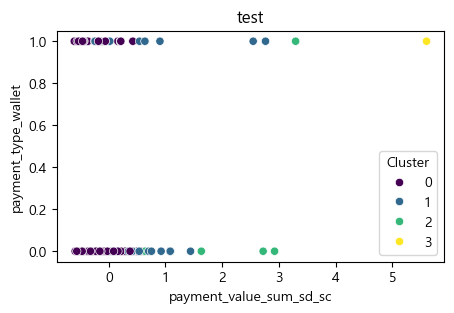

Year 2017, Month 5:


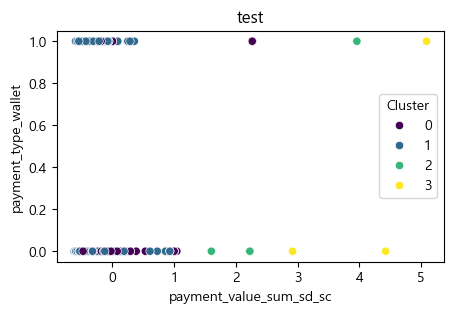

Year 2017, Month 6:


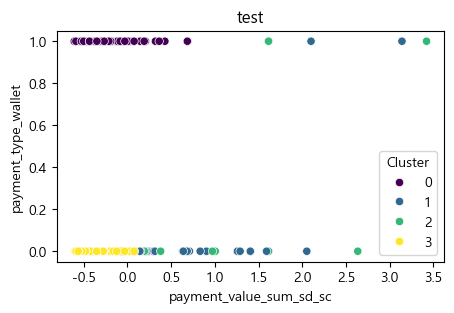

Year 2017, Month 7:


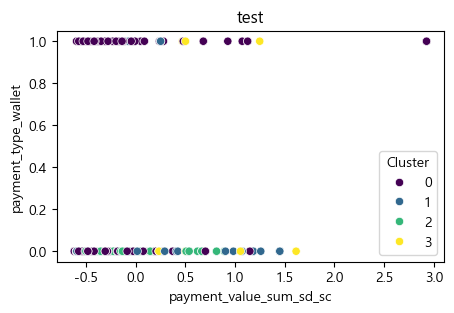

Year 2017, Month 8:


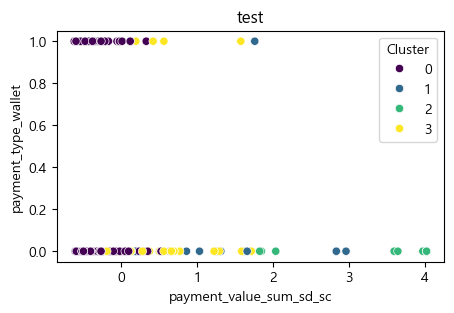

Year 2017, Month 9:


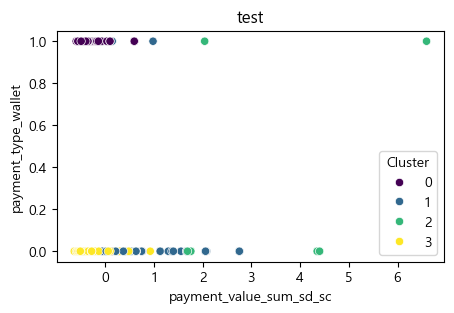

Year 2017, Month 10:


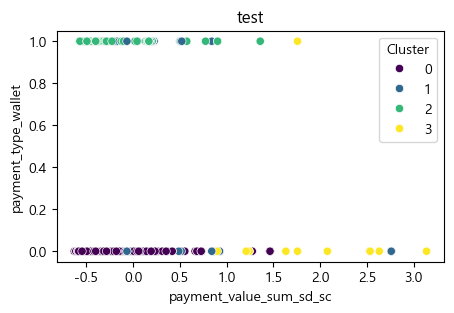

Year 2017, Month 11:


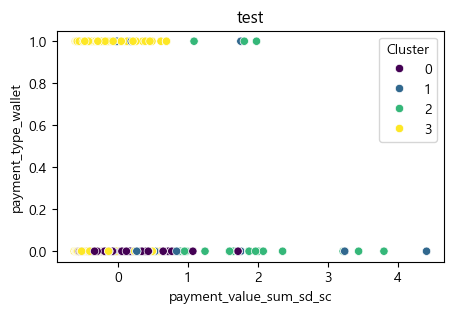

Year 2017, Month 12:


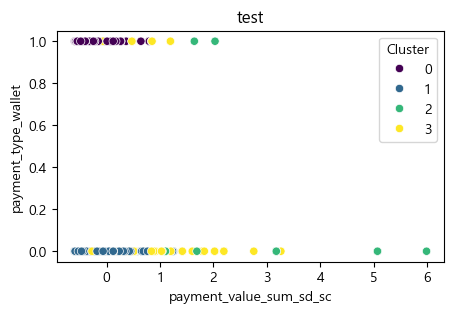

Year 2018, Month 1:


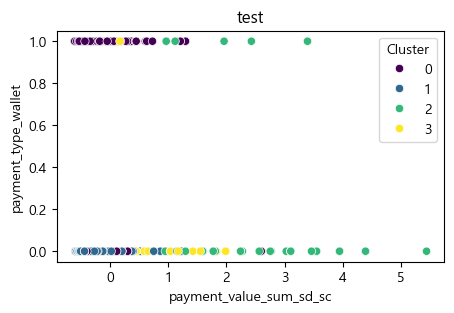

Year 2018, Month 2:


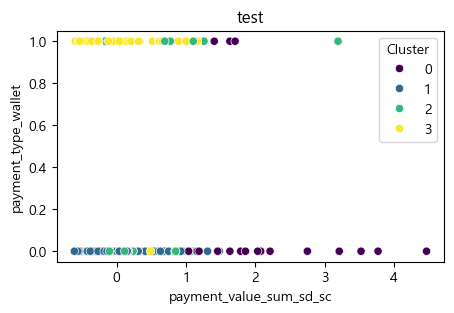

Year 2018, Month 3:


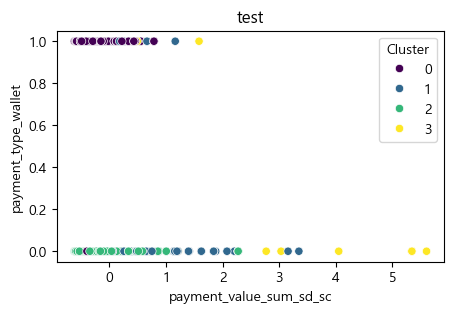

Year 2018, Month 4:


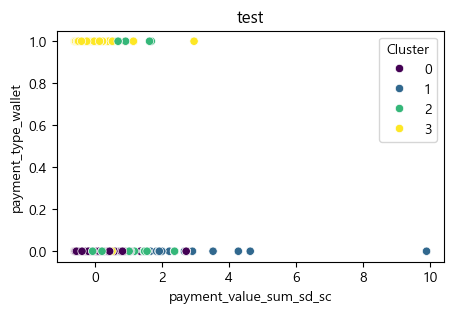

Year 2018, Month 5:


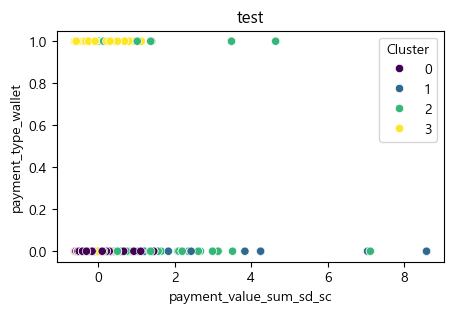

Year 2018, Month 6:


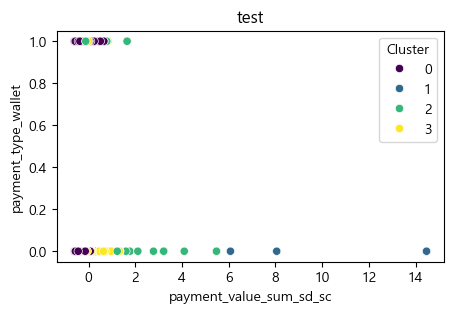

Year 2018, Month 7:


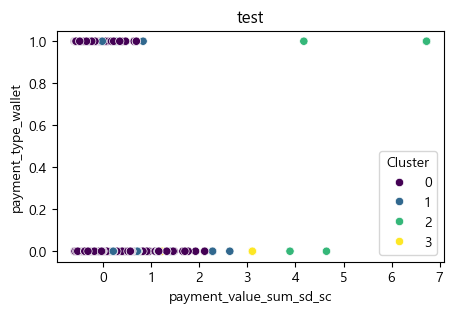

Year 2018, Month 8:


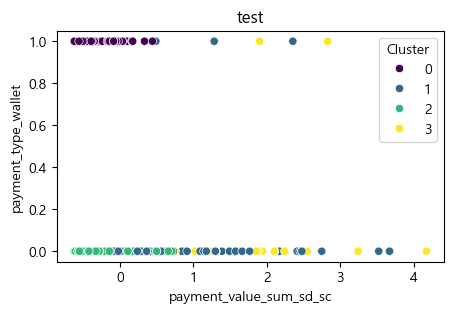

In [628]:

for i, (year, month, monthly_df) in enumerate(monthly_dfs):
    print(f"Year {year}, Month {month}:")
    # print(monthly_df['order_purchase_timestamp'].loc[:2].dt.strftime('%Y-%m'))
    # print(monthly_df['order_purchase_timestamp'].dt.strftime('%Y-%m').head(1))
    # kmeans 모델 생성
    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(monthly_df[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(monthly_df[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    monthly_df['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='payment_type_wallet', hue = 'Cluster', data=monthly_df, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('payment_type_wallet')
    plt.show()

# [전체] payment_value_sum_sd_sc

## vs payment_type_credit_card

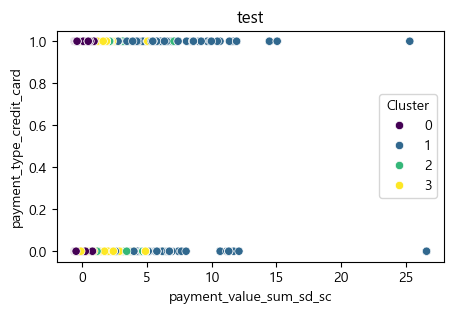

In [589]:

    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='payment_type_credit_card', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('payment_type_credit_card')
    plt.show()

In [592]:
print(len(retail_df_merged))
print(len(retail_df_merged[retail_df_merged['payment_type_credit_card'] == 1]))

30684
22629


신용카드를 사용한 고객의 결제액 범위가 훨씬 넓고, 개수가 더 많음.
예외로 신용카드를 사용하지 않고 큰 값을 지출한 고객이 있지만 (이상치)
대부분의 경우는 적은 값을 지불.

#저 payment_value_sum이 유난히 큰데 신용카드 사용안한 사람은 대체 정체가 뭘까...

houseware...
[furniture, bedroom] 
[sports, leisure]
상위 10퍼의 손님 모두 payment_type_wallet를 사용했음을 알 수 있음

In [610]:
retail_df_merged = retail_df_merged[retail_df_merged['customer_state_origin']== 'SP']

In [ ]:
retail_df_merged[retail_df_merged['payment_type_credit_card'] == 0].sort_values(by='payment_value_sum_sd_sc')[-30:]

## vs payment_type_debit_card

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\1880147162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


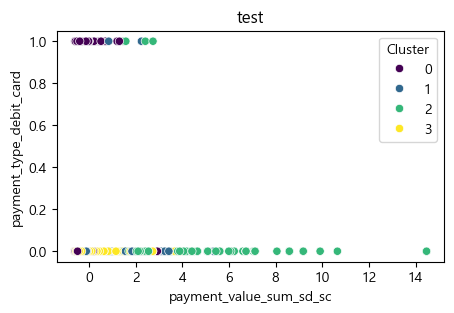

In [613]:

    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='payment_type_debit_card', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('payment_type_debit_card')
    plt.show()

In [614]:
print(len(retail_df_merged))
print(len(retail_df_merged[retail_df_merged['payment_type_debit_card'] == 1]))

12835
201


In [615]:
retail_df_merged[retail_df_merged['payment_type_debit_card'] == 1].sort_values(by='payment_value_sum_sd_sc')[-30:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
6047,dda16909ad9bfd9cded321b79e073749,d9e44c22fba903ca3843c1512e44f82c,delivered,2017-11-18 12:48:38,2017-11-18 13:55:30,1,79706e79825f7409ef032653a271fba2,7c67e1448b00f6e969d365cea6b010ab,189.99,41.28,1.0,debit_card,1.0,231.27,0.423806,"[office, furniture]",22800.0,120960.0,231.27,2017-11,0.0,1.0,0.0,0.0,1,1675466.29,1.373751,0.397155,0.226407,4.537996,SP,5.514796,0.195574,office_furniture,0.052438,1
25247,107184b32040eb4fb9bfad381805d105,d867d0c1c893268d9473255b0f8480c7,delivered,2018-06-25 20:11:07,2018-06-25 20:34:14,1,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,179.90,52.34,1.0,debit_card,1.0,232.24,0.423806,"[office, furniture]",16133.0,92925.0,232.24,2018-06,0.0,1.0,0.0,0.0,1,1352854.01,2.084423,0.341097,0.230097,3.334951,SP,3.739521,0.199214,office_furniture,0.052438,1
28909,e3d1d37007a4d31d2269ba250664f6b2,f3c438f7628d03c822aca24d3e7f60ea,delivered,2018-07-16 00:21:02,2018-07-16 00:30:14,1,43b54d1fc56ff394092a3dff6be2d39f,c70c1b0d8ca86052f45a432a38b73958,110.32,8.03,1.0,debit_card,1.0,236.70,0.423806,"[health, beauty]",150.0,990.0,236.70,2018-07,0.0,1.0,0.0,0.0,1,1391770.10,-0.762764,-0.045480,0.247063,-0.610186,SP,-0.516400,0.215951,health_beauty,0.309803,0
12303,e3d1d37007a4d31d2269ba250664f6b2,f3c438f7628d03c822aca24d3e7f60ea,delivered,2018-07-16 00:21:02,2018-07-16 00:30:14,2,c589625c8ccc7bfd2e8f1fb041e24c4a,c70c1b0d8ca86052f45a432a38b73958,110.32,8.03,1.0,debit_card,1.0,236.70,0.423806,"[health, beauty]",150.0,990.0,236.70,2018-07,0.0,1.0,0.0,0.0,1,1391770.10,-0.762764,-0.045480,0.247063,-0.610186,SP,-0.516400,0.215951,health_beauty,0.309803,0
13729,c58bd581144192869f091dd6fbabceea,31ecad36683b9b0ba61de1140f4857bf,delivered,2018-01-29 13:35:39,2018-01-29 14:38:24,1,dd5a5e7b2b76089d6415070e8d6d5456,9baf5cb77970f539089d09a38bcec5c3,225.99,12.79,1.0,debit_card,1.0,238.78,0.423806,[housewares],1450.0,20358.0,238.78,2018-01,0.0,1.0,0.0,0.0,1,1469974.38,-0.456905,0.597167,0.254976,0.220938,SP,-0.170239,0.223757,housewares,0.377786,0
16006,1585ebe77775265b8612b0e4fc614cd2,095445473b390ee22a754f4941b7b7da,delivered,2018-04-05 12:12:33,2018-04-06 13:09:03,1,2267f81f3634e3fdd5d27151ddad3c26,f181738b150df1f37cb0bd72e705b193,219.00,21.58,1.0,debit_card,1.0,240.58,0.423806,"[cool, stuff]",9650.0,27520.0,240.58,2018-04,0.0,1.0,0.0,0.0,1,1573819.86,0.107906,0.558331,0.261824,0.528276,SP,2.013241,0.230511,cool_stuff,0.309803,0
9220,30837e97d6e552e25ee411c7365bdbcd,8e2362db1bcd46ad2de37f1d63e7203e,delivered,2018-07-15 19:50:22,2018-07-16 20:30:41,1,76c73618750ec1718b6f51a96c498f93,709e16e2b25c7474d980076c6bfc4806,229.00,15.18,1.0,debit_card,1.0,244.18,0.423806,"[health, beauty]",575.0,5200.0,244.18,2018-07,0.0,1.0,0.0,0.0,1,1391770.10,-0.303333,0.613890,0.275519,-0.429525,SP,-0.403232,0.244021,health_beauty,0.309803,0
13588,1ff6ec2c3e9d8820643f43696482d2b9,e4bbc30179d3836f29479b8905476120,delivered,2018-07-24 00:14:31,2018-07-24 10:31:19,1,fb19ac22e32dfecea21afbdde4b97b5f,612170e34b97004b3ba37eae81836b4c,229.90,16.71,1.0,debit_card,1.0,246.61,0.423806,[telephony],100.0,3328.0,246.61,2018-07,0.0,1.0,0.0,0.0,1,1391770.10,-0.205021,0.618890,0.284763,-0.509857,SP,-0.529714,0.253140,telephony,0.164190,0
23298,0d80d0e27b1dc1e7eab3528b17464069,d7836df5fb04a1e677a6d091e5a14380,delivered,2018-08-21 19:44:49,2018-08-21 19:55:14,1,3a807175ca79ae358737db8127977d35,5d0363b33554

데빗카드 사용량은 극도로 적다.
가격에 주목한다면 구매제품의 가격대도 낮은 편임 (다른 지불방식을 쓰는 게 좋음)

## payment_type_voucher

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\810141340.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


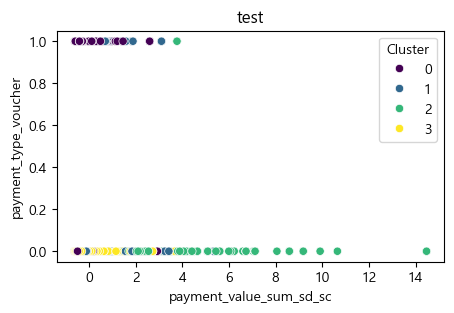

In [616]:

    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='payment_type_voucher', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('payment_type_voucher')
    plt.show()

In [617]:
print(len(retail_df_merged))
print(len(retail_df_merged[retail_df_merged['payment_type_voucher'] == 1]))

12835
630


In [618]:
retail_df_merged[retail_df_merged['payment_type_voucher'] == 1].sort_values(by='payment_value_sum_sd_sc')[-30:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
458,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,6.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
453,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,2.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
456,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,7.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
454,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,5.0,voucher,1.0,50.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.463176,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
455,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,3.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
457,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,9.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
452,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,4.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
451,dc96a12713fb7cbfd8feac4ab0b8f2a2,182ebbe49711dd49de4fbbdf4a999c10,delivered,2017-07-30 11:30:00,2017-07-30 11:43:23,1,1ffe365aa7583189e63f2fa4f060b269,80e6699fe29150b372a0c8a1ebf7dcc8,547.99,17.59,8.0,voucher,1.0,30.00,0.423806,"[sports, leisure]",5200.0,42000.0,565.58,2017-07,0.0,0.0,1.0,0.0,1,792862.63,-0.148476,2.386154,-0.539259,1.149645,SP,0.828304,1.450124,sports_leisure,0.309803,0
26661,dddc545a77663ef26d16778d03ef3bcd,0e2a10c8d1b35dca12057704d738bdb6,delivered,2018-02-06 11:34:34,2018-02-06 11:49:49,1,6781eab14bf137c9a168c67a29c92c29,8ae520247981aa06bc94abddf5f

바우처 사용량은 극도로 적다.
가격에 주목한다면 구매제품의 가격대도 낮은 편임 (다른 지불방식을 쓰는 게 좋음)

housewares
furniture living room

##  payment_type_wallet

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\1710717750.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


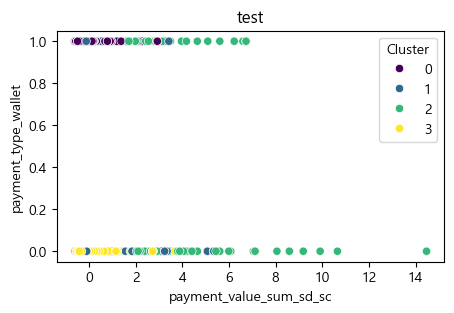

In [619]:

    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='payment_type_wallet', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('payment_type_wallet')
    plt.show()

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\2201387858.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


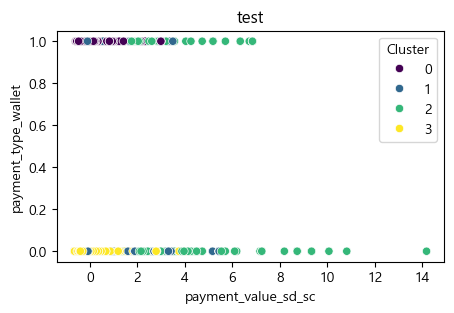

In [627]:

    kmeans = KMeans(n_clusters=4, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sd_sc', y='payment_type_wallet', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sd_sc')
    plt.ylabel('payment_type_wallet')
    plt.show()

In [620]:
print(len(retail_df_merged))
print(len(retail_df_merged[retail_df_merged['payment_type_wallet'] == 1]))

12835
2462


In [621]:
retail_df_merged[retail_df_merged['payment_type_wallet'] == 1].sort_values(by='payment_value_sum_sd_sc')[-30:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
13965,e9d40a10468b79b4c35c82f1bf078545,3ec83b54e0afb70def9480cd6b9097f7,delivered,2018-02-27 12:21:57,2018-03-01 02:50:46,3,b114bf337c0626166abe574eee9e3f32,7c67e1448b00f6e969d365cea6b010ab,149.94,21.70,1.0,wallet,1.0,1029.84,0.423806,"[office, furniture]",13350.0,70224.0,1029.84,2018-02,0.0,0.0,0.0,1.0,1,1431389.57,0.115616,0.174643,3.264305,2.360800,SP,2.998469,3.192332,office_furniture,0.052438,1
15760,1e30314e6dd7717655ff9f2f186df393,f4c9f17baaf056a2b3b34ca484270e24,delivered,2017-04-22 10:30:14,2017-04-25 08:25:46,1,c3eb7064c36408a9bfc77a42d6ab993c,17f51e7198701186712e53a39c564617,990.00,67.29,1.0,wallet,1.0,1057.29,0.423806,"[health, beauty]",30000.0,251625.0,1057.29,2017-04,0.0,0.0,0.0,1.0,1,484812.57,3.045052,4.841902,3.368729,10.145124,SP,7.431997,3.295343,health_beauty,0.309803,1
7532,2c559a6f1ac48c4f100f4775a1362ea1,29bbf509bf085413d69208f1547f76e0,delivered,2018-01-10 10:50:11,2018-01-11 18:11:25,1,738067b78d178e457fa0dc6db5d2cc58,30829ded4523ab9224b93bc49a62c95f,523.19,18.41,1.0,wallet,1.0,1083.20,0.423806,"[computers, accessories]",300.0,1536.0,1083.20,2018-01,0.0,0.0,0.0,1.0,1,1469974.38,-0.095786,2.248369,3.467295,-0.586756,SP,-0.476458,3.392574,computers_accessories,0.164190,2
7533,2c559a6f1ac48c4f100f4775a1362ea1,29bbf509bf085413d69208f1547f76e0,delivered,2018-01-10 10:50:11,2018-01-11 18:11:25,2,738067b78d178e457fa0dc6db5d2cc58,30829ded4523ab9224b93bc49a62c95f,523.19,18.41,1.0,wallet,1.0,1083.20,0.423806,"[computers, accessories]",300.0,1536.0,1083.20,2018-01,0.0,0.0,0.0,1.0,1,1469974.38,-0.095786,2.248369,3.467295,-0.586756,SP,-0.476458,3.392574,computers_accessories,0.164190,2
30287,f3d113574c163b8642fb44302c8fe0c9,96f9779ab3aada4f274112897f433d1d,delivered,2017-06-23 21:50:23,2017-06-27 04:03:14,1,9fa7e05ae5cddeb74ff2fe5046b742db,17f51e7198701186712e53a39c564617,990.00,100.68,1.0,wallet,1.0,1090.68,0.423806,"[health, beauty]",30000.0,251625.0,1090.68,2017-06,0.0,0.0,0.0,1.0,1,638324.38,5.190562,4.841902,3.495750,10.145124,SP,7.431997,3.420644,health_beauty,0.309803,1
9280,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,3,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9278,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,1,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9279,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,2,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9692,7c749191ee3a17f34cbfcf6ddd2009ac,c114c44566c2d172b520bc3c8785ffdf,delivered,2017-05-09 12:36:05,2017-05-10 06:35:31,1,f22c9d6ce2431ff939aad39e026cc7ef,c84

가격에 주목한다면 구매제품의 가격대도 낮은 편임 (다른 지불방식을 쓰는 게 좋음)
대부분이 신용카드이지만, 2위로 현금을 사용함

housewares
furniture bedroom

##  product_volume_sd_sc

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\1067203886.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


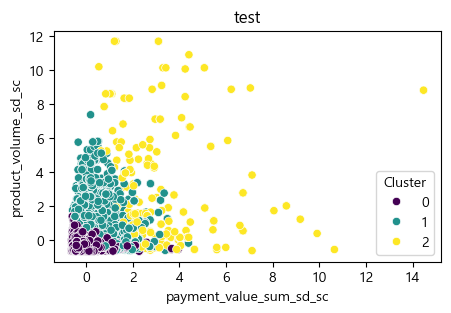

In [625]:

    kmeans = KMeans(n_clusters=3, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sum_sd_sc', y='product_volume_sd_sc', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sum_sd_sc')
    plt.ylabel('product_volume_sd_sc')
    plt.show()

C:\Users\양영\AppData\Local\Temp\ipykernel_7652\3879385207.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df_merged['Cluster'] = clusters


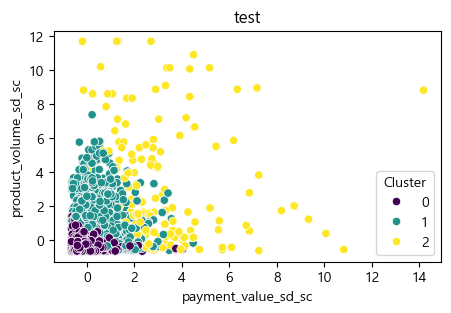

In [626]:

    kmeans = KMeans(n_clusters=3, random_state=42)

    # kmeans 모델 훈련
    kmeans.fit(retail_df_merged[col_needed])

    # 클러스터 할당
    clusters = kmeans.predict(retail_df_merged[col_needed])

    # 클러스터 할당 결과를 데이터프레임에 추가
    retail_df_merged['Cluster'] = clusters
    # bad_customers['Cluster'] = clusters

    plt.figure(figsize=(5, 3))
    # sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
    sns.scatterplot(x='payment_value_sd_sc', y='product_volume_sd_sc', hue = 'Cluster', data=retail_df_merged, palette='viridis')
    # kmeans 와 pca 
    plt.title('test')
    plt.xlabel('payment_value_sd_sc')
    plt.ylabel('product_volume_sd_sc')
    plt.show()

In [ ]:
print(len(retail_df_merged))
print(len(retail_df_merged[retail_df_merged['payment_type_wallet'] == 1]))

12835
2462


In [ ]:
retail_df_merged[retail_df_merged['payment_type_wallet'] == 1].sort_values(by='payment_value_sum_sd_sc')[-30:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,shipping_charges,payment_sequential,payment_type,payment_installments,payment_value,customer_state,product_category_name,product_weight_g,product_volume,payment_value_sum,payment_monthly,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_wallet,payment_installments_category,payment_monthly_sum,shipping_charges_sd_sc,price_sd_sc,payment_value_sd_sc,product_volume_sd_sc,customer_state_origin,product_weight_g_sd_sc,payment_value_sum_sd_sc,product_category_name_origin,product_category_name_cf_en,Cluster
13965,e9d40a10468b79b4c35c82f1bf078545,3ec83b54e0afb70def9480cd6b9097f7,delivered,2018-02-27 12:21:57,2018-03-01 02:50:46,3,b114bf337c0626166abe574eee9e3f32,7c67e1448b00f6e969d365cea6b010ab,149.94,21.70,1.0,wallet,1.0,1029.84,0.423806,"[office, furniture]",13350.0,70224.0,1029.84,2018-02,0.0,0.0,0.0,1.0,1,1431389.57,0.115616,0.174643,3.264305,2.360800,SP,2.998469,3.192332,office_furniture,0.052438,1
15760,1e30314e6dd7717655ff9f2f186df393,f4c9f17baaf056a2b3b34ca484270e24,delivered,2017-04-22 10:30:14,2017-04-25 08:25:46,1,c3eb7064c36408a9bfc77a42d6ab993c,17f51e7198701186712e53a39c564617,990.00,67.29,1.0,wallet,1.0,1057.29,0.423806,"[health, beauty]",30000.0,251625.0,1057.29,2017-04,0.0,0.0,0.0,1.0,1,484812.57,3.045052,4.841902,3.368729,10.145124,SP,7.431997,3.295343,health_beauty,0.309803,1
7532,2c559a6f1ac48c4f100f4775a1362ea1,29bbf509bf085413d69208f1547f76e0,delivered,2018-01-10 10:50:11,2018-01-11 18:11:25,1,738067b78d178e457fa0dc6db5d2cc58,30829ded4523ab9224b93bc49a62c95f,523.19,18.41,1.0,wallet,1.0,1083.20,0.423806,"[computers, accessories]",300.0,1536.0,1083.20,2018-01,0.0,0.0,0.0,1.0,1,1469974.38,-0.095786,2.248369,3.467295,-0.586756,SP,-0.476458,3.392574,computers_accessories,0.164190,2
7533,2c559a6f1ac48c4f100f4775a1362ea1,29bbf509bf085413d69208f1547f76e0,delivered,2018-01-10 10:50:11,2018-01-11 18:11:25,2,738067b78d178e457fa0dc6db5d2cc58,30829ded4523ab9224b93bc49a62c95f,523.19,18.41,1.0,wallet,1.0,1083.20,0.423806,"[computers, accessories]",300.0,1536.0,1083.20,2018-01,0.0,0.0,0.0,1.0,1,1469974.38,-0.095786,2.248369,3.467295,-0.586756,SP,-0.476458,3.392574,computers_accessories,0.164190,2
30287,f3d113574c163b8642fb44302c8fe0c9,96f9779ab3aada4f274112897f433d1d,delivered,2017-06-23 21:50:23,2017-06-27 04:03:14,1,9fa7e05ae5cddeb74ff2fe5046b742db,17f51e7198701186712e53a39c564617,990.00,100.68,1.0,wallet,1.0,1090.68,0.423806,"[health, beauty]",30000.0,251625.0,1090.68,2017-06,0.0,0.0,0.0,1.0,1,638324.38,5.190562,4.841902,3.495750,10.145124,SP,7.431997,3.420644,health_beauty,0.309803,1
9280,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,3,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9278,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,1,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9279,efd36975d7d35f5e51dc4e13aabc0f2d,7b9b082ceaa61d7bc565cdad86597669,delivered,2018-05-03 19:53:54,2018-05-05 03:33:43,2,a94db861b4ea1c79704586f07c8cdbc3,32b8764b4ef628b53608fc34011fcc13,349.00,20.32,1.0,wallet,1.0,1107.96,0.423806,[housewares],12150.0,44880.0,1107.96,2018-05,0.0,0.0,0.0,1.0,1,1582326.72,0.026943,1.280593,3.561487,1.273232,SP,2.678936,3.485490,housewares,0.377786,2
9692,7c749191ee3a17f34cbfcf6ddd2009ac,c114c44566c2d172b520bc3c8785ffdf,delivered,2017-05-09 12:36:05,2017-05-10 06:35:31,1,f22c9d6ce2431ff939aad39e026cc7ef,c84

가격에 주목한다면 구매제품의 가격대도 낮은 편임 (다른 지불방식을 쓰는 게 좋음)
대부분이 신용카드이지만, 2위로 현금을 사용함

housewares
furniture bedroom

## payment_type_wallet